# Taller 4 - UNET aplicado a la Segmentación Semántica

Profesor: Dr. Ing. Rodrigo Salas, Universidad de Valparaíso

[rodrigo.salas@uv.cl](mailto:rodrigo.salas@uv.cl)

Cursillo de Deep Learning aplicado a Imágenes

**Simposio Internacional de Estadística 2025**

**Pasto, Colombia**

# 🧠 Workshop: Segmentación de Tumores Cerebrales con Deep Learning

## Objetivo del Workshop
En este workshop aprenderemos a implementar un modelo U-Net para la **segmentación automática de tumores cerebrales** usando imágenes de resonancia magnética multimodal del dataset BraTS.


# 1. Introducción y Preparación

## 🧬 Dataset BraTS (Brain Tumor Segmentation)

El **BraTS Challenge** (https://www.synapse.org/Synapse:syn53708126/wiki/626320) es una competencia anual que se enfoca en la segmentación de tumores cerebrales usando imágenes de resonancia magnética multimodal.

#
#  ![BraTS Dataset](./brats_img.png)
#


### 📊 Modalidades de imagen disponibles:

- **T1**: Imágenes ponderadas en T1 (anatomía básica)
- **T1ce**: T1 con contraste (realza tumores)  
- **T2**: Imágenes ponderadas en T2 (mejor contraste de tejidos blandos)
- **FLAIR**: Fluid Attenuated Inversion Recovery (suprime señal del líquido cefalorraquídeo)

#
#  <img src="./bratsmri.png" alt="BraTS MRI">
#


### 🎯 Clases de segmentación:

- **Whole Tumor (WT)**: Todo el tumor (incluye todas las sub-regiones)
- **Tumor Core (TC)**: Núcleo del tumor (excluye edema)
- **Enhancing Tumor (ET)**: Tumor que realza con contraste

#
#  <img src="./bratsclasses2.jpg" alt="BraTS Class">
#


### 📐 Formato de datos:

- **Formato**: NIfTI (.nii.gz) - estándar en neuroimágenes
- **Dimensiones**: [H, W, D] = [240, 240, 155] voxels


In [ ]:
# 🔧 Instalación de librerías necesarias
#print("📦 Instalando librerías para el workshop...")

# Instalar librerías específicas para imágenes médicas
#!pip install monai nibabel matplotlib torchsummary -q

# Importar librerías principales
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from monai import transforms
from torchsummary import summary
import os
import warnings
warnings.filterwarnings('ignore')

# Configurar dispositivo (GPU si está disponible)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🔥 Usando dispositivo: {device}")

# Configurar semilla para reproducibilidad
torch.manual_seed(42)
np.random.seed(42)

print("✅ Librerías instaladas y configuradas correctamente!")


📦 Instalando librerías para el workshop...
🔥 Usando dispositivo: cuda
✅ Librerías instaladas y configuradas correctamente!


In [ ]:
# 📁 Carga de datos
print("📥 Cargando datos del BraTS dataset...")

# Ruta donde están guardados los datos
data_path = './BraTS2021_Training_Data'

# Crear una carpeta para guardar datos procesados
if not os.path.exists('brats_data'):
    os.makedirs('brats_data')

def load_brats_case(case_path):
    """
    Esta función carga un paciente del dataset BraTS.
    Busca los archivos de cada tipo de imagen y los carga en memoria.
    """
    # Diccionario para guardar todas las imágenes del paciente
    case_data = {}

    # Obtener lista de todos los archivos en la carpeta del paciente
    files_in_folder = os.listdir(case_path)

    # Revisar cada archivo uno por uno
    for file_name in files_in_folder:
        # Solo procesar archivos que terminen en .nii.gz
        if file_name.endswith('.nii.gz'):
            # Crear la ruta completa del archivo
            full_file_path = os.path.join(case_path, file_name)

            # Verificar qué tipo de imagen es según el nombre del archivo
            if '_t1.nii.gz' in file_name:
                # Cargar imagen T1
                img = nib.load(full_file_path)
                case_data['t1'] = img.get_fdata()

            elif '_t1ce.nii.gz' in file_name:
                # Cargar imagen T1 con contraste
                img = nib.load(full_file_path)
                case_data['t1ce'] = img.get_fdata()

            elif '_t2.nii.gz' in file_name:
                # Cargar imagen T2
                img = nib.load(full_file_path)
                case_data['t2'] = img.get_fdata()

            elif '_flair.nii.gz' in file_name:
                # Cargar imagen FLAIR
                img = nib.load(full_file_path)
                case_data['flair'] = img.get_fdata()

            elif '_seg.nii.gz' in file_name:
                # Cargar máscara de segmentación (etiquetas del tumor)
                img = nib.load(full_file_path)
                case_data['seg'] = img.get_fdata()

    return case_data

# Paso 1: Obtener lista de todos los pacientes disponibles
all_folders = os.listdir(data_path)
cases = []
for folder in all_folders:
    folder_path = os.path.join(data_path, folder)
    if os.path.isdir(folder_path):
        cases.append(folder)

# Paso 2: Tomar el primer paciente como ejemplo
first_case = cases[0]
case_path = os.path.join(data_path, first_case)
print(f"🔍 Cargando caso: {first_case}")

# Paso 3: Cargar todas las imágenes del primer paciente
sample_data = load_brats_case(case_path)

# Mostrar información sobre los datos cargados
print("✅ Datos reales cargados!")
print(f"📊 Dimensiones: {sample_data['t1'].shape}")

# Mostrar qué clases de tumor están presentes
unique_labels = np.unique(sample_data['seg'])
print(f"🎯 Clases: {unique_labels}")


📥 Cargando datos del BraTS dataset...
🔍 Cargando caso: BraTS2021_01394
✅ Datos reales cargados!
📊 Dimensiones: (240, 240, 155)
🎯 Clases: [0. 1. 2. 4.]


# 2. Exploración de Datos y Visualización

## 👁️ Visualización de imágenes médicas

Para entender mejor nuestros datos, visualizaremos diferentes cortes y modalidades. Las imágenes médicas 3D se exploran típicamente en tres planos anatómicos:

- **Axial**: Cortes horizontales (como si miraras desde arriba)
- **Coronal**: Cortes frontales (como si miraras de frente)  
- **Sagital**: Cortes laterales (como si miraras de perfil)

### 🎨 Utilidad clínica de cada modalidad:

- **T1**: Excelente contraste anatómico, buena definición de estructuras
- **T1ce**: Resalta tumores que captan contraste (tumores activos)
- **T2**: Mejor visualización de edema y líquido
- **FLAIR**: Suprime señal del LCR, mejor para ver lesiones periventriculares


🧠 Vamos a visualizar las 4 modalidades MRI de nuestro paciente...
Cada modalidad nos muestra información diferente del cerebro
📍 Mostrando el corte número 77 (de 155 cortes totales)


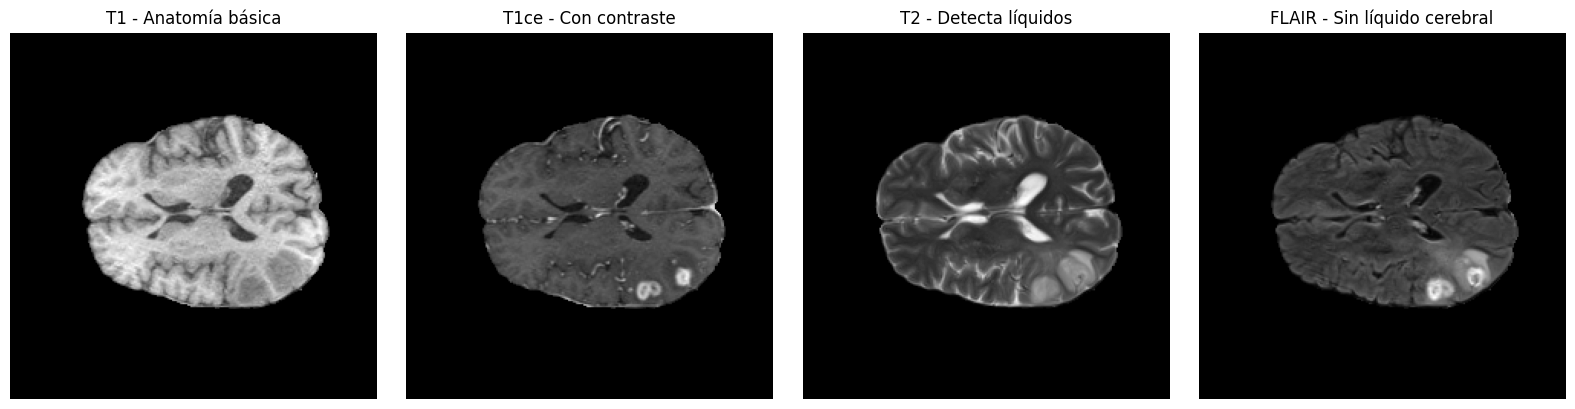


💡 TIP: Para ver un corte diferente, cambia el valor de 'slice_to_view'
   Puedes usar valores entre 0 y 155
   Ejemplo: slice_to_view = 50 (más abajo) o slice_to_view = 100 (más arriba)


In [ ]:
# 🖼️ Visualización básica de las 4 modalidades MRI
print("🧠 Vamos a visualizar las 4 modalidades MRI de nuestro paciente...")
print("Cada modalidad nos muestra información diferente del cerebro")

# Primero, vamos a crear una figura con 4 espacios para nuestras imágenes
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

# Elegir qué corte queremos ver (77 es aproximadamente el centro del cerebro)
slice_to_view = 77
print(f"📍 Mostrando el corte número {slice_to_view} (de 155 cortes totales)")


# Modalidad 1: T1
axes[0].imshow(sample_data['t1'][:, :, slice_to_view], cmap='gray')
axes[0].set_title('T1 - Anatomía básica', fontsize=12)
axes[0].axis('off')

# Modalidad 2: T1ce (T1 con contraste)
axes[1].imshow(sample_data['t1ce'][:, :, slice_to_view], cmap='gray')
axes[1].set_title('T1ce - Con contraste', fontsize=12)
axes[1].axis('off')

# Modalidad 3: T2
axes[2].imshow(sample_data['t2'][:, :, slice_to_view], cmap='gray')
axes[2].set_title('T2 - Detecta líquidos', fontsize=12)
axes[2].axis('off')

# Modalidad 4: FLAIR
axes[3].imshow(sample_data['flair'][:, :, slice_to_view], cmap='gray')
axes[3].set_title('FLAIR - Sin líquido cerebral', fontsize=12)
axes[3].axis('off')

# Mostrar las imágenes
plt.tight_layout()
plt.show()

print("\n💡 TIP: Para ver un corte diferente, cambia el valor de 'slice_to_view'")
print("   Puedes usar valores entre 0 y 155")
print("   Ejemplo: slice_to_view = 50 (más abajo) o slice_to_view = 100 (más arriba)")


Análisis de orientaciones anatómicas en neuroimágenes
Las imágenes MRI son volúmenes 3D que podemos analizar en tres planos ortogonales

Configuración del análisis:
Modalidad MRI: t1ce
Corte axial: 77
Dimensiones del volumen: (240, 240, 155) (alto x ancho x profundidad)


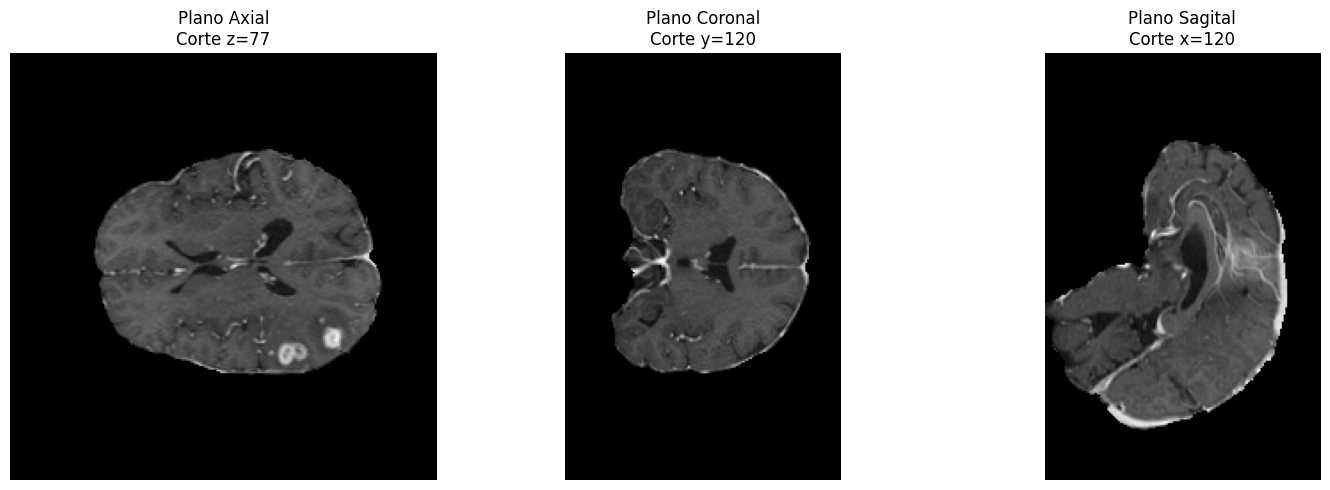


Ejercicios de análisis:
1. Modifique 'corte_seleccionado' (rango: 0-155) para explorar diferentes niveles
2. Compare modalidades cambiando 'modalidad_mri' a: 't1', 't2', 'flair'
3. Identifique las diferencias de contraste entre modalidades
4. Observe cómo cambia la visualización en los diferentes planos


In [ ]:
# 📐 Análisis de cortes anatómicos en imágenes MRI 3D
print("Análisis de orientaciones anatómicas en neuroimágenes")
print("Las imágenes MRI son volúmenes 3D que podemos analizar en tres planos ortogonales")

def mostrar_planos_anatomicos(volumen_3d, corte_axial=77):
    """
    Visualiza un volumen MRI 3D en los tres planos anatómicos estándar

    Parámetros:
    -----------
    volumen_3d : numpy.ndarray
        Volumen de imagen 3D con dimensiones (x, y, z)
    corte_axial : int
        Índice del corte axial a visualizar (dirección z)

    Descripción de planos:
    - Axial: Plano horizontal (xy), vista desde arriba
    - Coronal: Plano frontal (xz), vista desde el frente
    - Sagital: Plano lateral (yz), vista desde el lado
    """

    # Crear figura con tres subplots
    fig, ejes = plt.subplots(1, 3, figsize=(15, 5))

    dimensiones = volumen_3d.shape
    print(f"Dimensiones del volumen: {dimensiones} (alto x ancho x profundidad)")

    # Plano Axial (horizontal): corte en dirección z
    ejes[0].imshow(volumen_3d[:, :, corte_axial], cmap='gray')
    ejes[0].set_title(f'Plano Axial\nCorte z={corte_axial}')
    ejes[0].axis('off')

    # Plano Coronal (frontal): corte en dirección y
    indice_coronal = dimensiones[1] // 2
    ejes[1].imshow(volumen_3d[:, indice_coronal, :], cmap='gray')
    ejes[1].set_title(f'Plano Coronal\nCorte y={indice_coronal}')
    ejes[1].axis('off')

    # Plano Sagital (lateral): corte en dirección x
    indice_sagital = dimensiones[0] // 2
    ejes[2].imshow(volumen_3d[indice_sagital, :, :], cmap='gray')
    ejes[2].set_title(f'Plano Sagital\nCorte x={indice_sagital}')
    ejes[2].axis('off')

    plt.tight_layout()
    plt.show()

# Variables de configuración para el análisis
corte_seleccionado = 77  # Índice del corte axial a analizar
modalidad_mri = 't1ce'   # Modalidad de imagen: 't1', 't1ce', 't2', 'flair'

print(f"\nConfiguración del análisis:")
print(f"Modalidad MRI: {modalidad_mri}")
print(f"Corte axial: {corte_seleccionado}")

# Ejecutar visualización
mostrar_planos_anatomicos(sample_data[modalidad_mri], corte_seleccionado)

print("\nEjercicios de análisis:")
print("1. Modifique 'corte_seleccionado' (rango: 0-155) para explorar diferentes niveles")
print("2. Compare modalidades cambiando 'modalidad_mri' a: 't1', 't2', 'flair'")
print("3. Identifique las diferencias de contraste entre modalidades")
print("4. Observe cómo cambia la visualización en los diferentes planos")


📊 ANÁLISIS DEL TUMOR
Tamaño del volumen: (240, 240, 155)
Clases encontradas: [0. 1. 2. 4.]

Conteo de vóxeles:
  NCR/NET (núcleo): 317 vóxeles
  Edema: 47,506 vóxeles
  Tumor Activo: 4,409 vóxeles
  Fondo: 8,875,768 vóxeles

Total tumor: 52,232 vóxeles (0.6%)

🎛️ CONFIGURACIÓN DE VISUALIZACIÓN
Corte: 77
Modalidad: t1ce
Transparencia: 0.5

En el corte 77:
  Área de tumor: 2.3%

🎨 VISUALIZACIONES
1. Máscaras de segmentación:


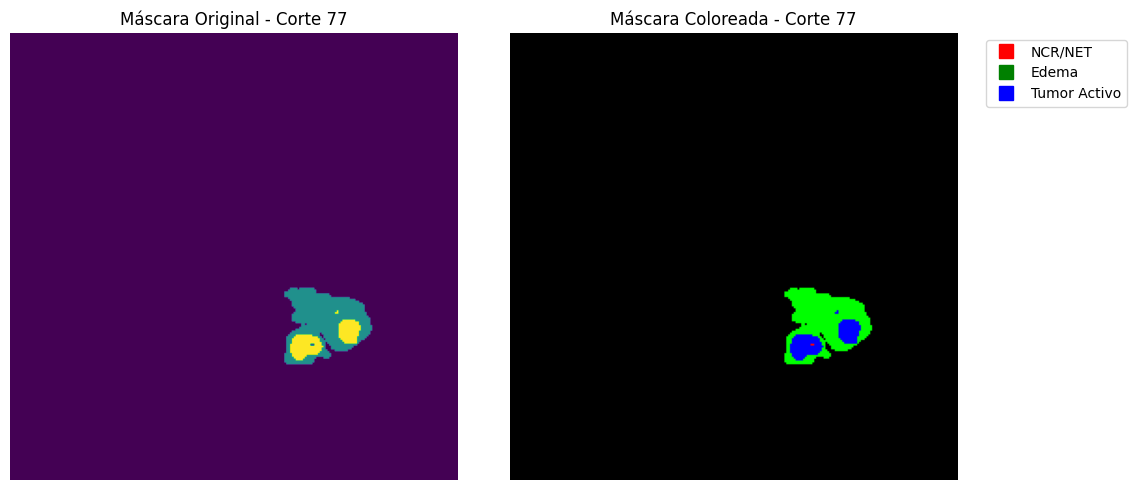

2. Superposición imagen-tumor:


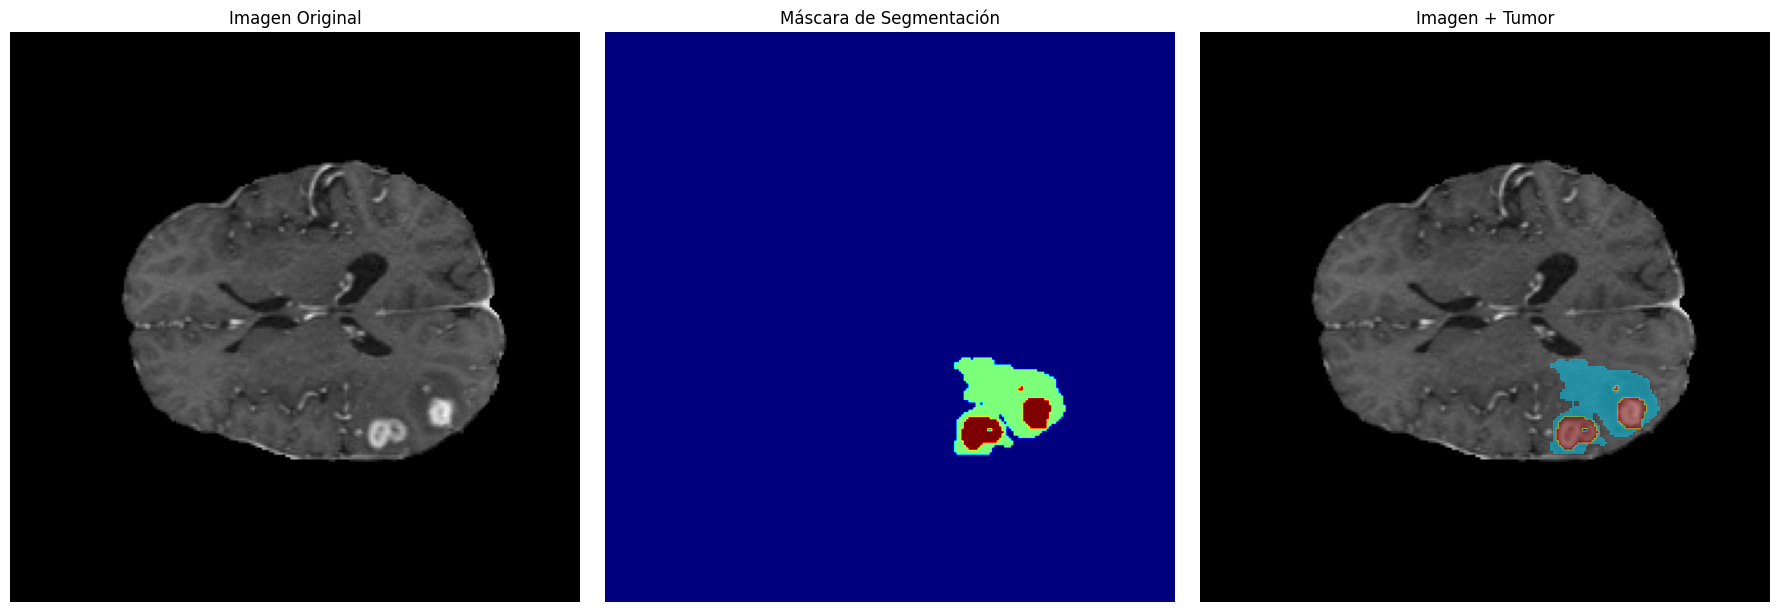


🎓 EJERCICIOS PRÁCTICOS
1. Cambia 'corte_a_ver' para explorar diferentes niveles
2. Prueba diferentes modalidades ('t1', 't1ce', 't2', 'flair')
3. Ajusta la 'transparencia' para mejor visualización
4. Encuentra el corte con mayor área de tumor
5. Compara cómo se ve el tumor en diferentes modalidades


In [ ]:
# 🎨 Visualización de máscaras de segmentación
def mostrar_mascara_tumor(mascara_segmentacion, corte=77):
    """
    Muestra la máscara de segmentación con colores para cada tipo de tumor
    """
    # Crear figura con dos imágenes lado a lado
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Obtener el corte 2D
    corte_2d = mascara_segmentacion[:, :, corte]

    # Colores para cada clase de tumor
    colores = {
        0: [0, 0, 0],      # Fondo - Negro
        1: [1, 0, 0],      # NCR/NET - Rojo
        2: [0, 1, 0],      # Edema - Verde
        4: [0, 0, 1]       # Tumor Activo - Azul
    }

    # Crear imagen a color
    imagen_color = np.zeros((corte_2d.shape[0], corte_2d.shape[1], 3))
    for clase, color in colores.items():
        imagen_color[corte_2d == clase] = color

    # Mostrar máscara original (números)
    ax1.imshow(corte_2d, cmap='viridis')
    ax1.set_title(f'Máscara Original - Corte {corte}')
    ax1.axis('off')

    # Mostrar máscara con colores
    ax2.imshow(imagen_color)
    ax2.set_title(f'Máscara Coloreada - Corte {corte}')
    ax2.axis('off')

    # Crear leyenda simple
    nombres_clase = {1: 'NCR/NET', 2: 'Edema', 4: 'Tumor Activo'}
    colores_leyenda = {1: 'red', 2: 'green', 4: 'blue'}

    for clase in np.unique(corte_2d):
        if clase in nombres_clase:
            ax2.plot([], [], 's', color=colores_leyenda[clase],
                    markersize=10, label=nombres_clase[clase])

    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

def mostrar_superposicion(imagen, mascara, corte=77, transparencia=0.5):
    """
    Superpone la máscara sobre la imagen MRI original
    """
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

    # Obtener cortes
    corte_imagen = imagen[:, :, corte]
    corte_mascara = mascara[:, :, corte]

    # 1. Imagen original
    ax1.imshow(corte_imagen, cmap='gray')
    ax1.set_title('Imagen Original')
    ax1.axis('off')

    # 2. Solo la máscara
    ax2.imshow(corte_mascara, cmap='jet')
    ax2.set_title('Máscara de Segmentación')
    ax2.axis('off')

    # 3. Superposición
    ax3.imshow(corte_imagen, cmap='gray')
    # Ocultar el fondo y mostrar solo el tumor
    tumor_visible = np.ma.masked_where(corte_mascara == 0, corte_mascara)
    ax3.imshow(tumor_visible, cmap='jet', alpha=transparencia)
    ax3.set_title('Imagen + Tumor')
    ax3.axis('off')

    plt.tight_layout()
    plt.show()

# === ESTADÍSTICAS DEL TUMOR ===
print("📊 ANÁLISIS DEL TUMOR")
print("=" * 40)

mascara = sample_data['seg']
print(f"Tamaño del volumen: {mascara.shape}")

# Contar cada tipo de tejido
clases_presentes = np.unique(mascara)
print(f"Clases encontradas: {clases_presentes}")

nombres_tejido = {
    0: 'Fondo',
    1: 'NCR/NET (núcleo)',
    2: 'Edema',
    4: 'Tumor Activo'
}

# Calcular vóxeles por clase
print("\nConteo de vóxeles:")
tumor_total = 0
for clase in [1, 2, 4]:  # Solo clases de tumor
    cantidad = np.sum(mascara == clase)
    tumor_total += cantidad
    print(f"  {nombres_tejido[clase]}: {cantidad:,} vóxeles")

fondo = np.sum(mascara == 0)
total = mascara.size
print(f"  {nombres_tejido[0]}: {fondo:,} vóxeles")
print(f"\nTotal tumor: {tumor_total:,} vóxeles ({tumor_total/total*100:.1f}%)")

# === CONFIGURACIÓN SIMPLE ===
print("\n🎛️ CONFIGURACIÓN DE VISUALIZACIÓN")
print("=" * 40)

# Variables fáciles de cambiar
corte_a_ver = 77           # Cambiar entre 0-154
modalidad = 't1ce'         # Opciones: 't1', 't1ce', 't2', 'flair'
transparencia = 0.5        # Entre 0.0 y 1.0

print(f"Corte: {corte_a_ver}")
print(f"Modalidad: {modalidad}")
print(f"Transparencia: {transparencia}")

# Análisis del corte específico
corte_actual = mascara[:, :, corte_a_ver]
pixeles_tumor = np.sum(corte_actual > 0)
pixeles_totales = corte_actual.size
porcentaje_tumor = (pixeles_tumor / pixeles_totales) * 100

print(f"\nEn el corte {corte_a_ver}:")
print(f"  Área de tumor: {porcentaje_tumor:.1f}%")

# === VISUALIZACIONES ===
print("\n🎨 VISUALIZACIONES")
print("=" * 40)

print("1. Máscaras de segmentación:")
mostrar_mascara_tumor(mascara, corte_a_ver)

print("2. Superposición imagen-tumor:")
mostrar_superposicion(sample_data[modalidad], mascara, corte_a_ver, transparencia)

# === EJERCICIOS PRÁCTICOS ===
print("\n🎓 EJERCICIOS PRÁCTICOS")
print("=" * 40)
print("1. Cambia 'corte_a_ver' para explorar diferentes niveles")
print("2. Prueba diferentes modalidades ('t1', 't1ce', 't2', 'flair')")
print("3. Ajusta la 'transparencia' para mejor visualización")
print("4. Encuentra el corte con mayor área de tumor")
print("5. Compara cómo se ve el tumor en diferentes modalidades")


# 3. Arquitectura U-Net

## 🏗️ ¿Por qué U-Net para imágenes médicas?

La arquitectura **U-Net** fue diseñada específicamente para segmentación de imágenes biomédicas y se ha convertido en el estándar de facto. Sus ventajas principales son:

### ✅ Ventajas de U-Net:

1. **Preservación espacial**: Mantiene la resolución espacial de la entrada
2. **Skip connections**: Conecta capas del encoder con el decoder
3. **Eficiencia con pocos datos**: Funciona bien con datasets pequeños
4. **Localización precisa**: Combina contexto global con detalles locales

### 🖼️ Arquitectura U-Net visualizada:

![U-Net Architecture](./unet.png)

*Figura: Arquitectura U-Net completa mostrando el encoder (izquierda), bottleneck (centro) y decoder (derecha) con skip connections*

### 🔧 Componentes principales:

- **Encoder (Contraction path)**: Extrae características y reduce resolución
- **Decoder (Expansion path)**: Reconstruye la segmentación a resolución original
- **Skip connections**: Transfieren información detallada del encoder al decoder
- **Bottleneck**: Punto más profundo con máximo contexto

### 📐 Arquitectura en detalle:

```
Input (4, 240, 240) → [Encoder] → Bottleneck → [Decoder] → Output (3, 240, 240)
                         ↓                         ↑
                    Skip connections ──────────────┘
```

- **Input**: 4 modalidades MRI (T1, T1ce, T2, FLAIR)
- **Output**: 3 clases (WT, TC, ET) + background


In [ ]:
# 🧱 Implementación modular de U-Net

class DoubleConv(nn.Module):
    """
    Bloque de doble convolución: Conv2D -> BatchNorm -> ReLU -> Conv2D -> BatchNorm -> ReLU
    """
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels

        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """
    Bloque de downsampling: MaxPool2D -> DoubleConv
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """
    Bloque de upsampling: Upsample -> Conv2D -> concatenate skip connection -> DoubleConv
    """
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # Usar upsampling bilineal o convolución transpuesta
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        # x1: salida del nivel anterior, x2: skip connection
        x1 = self.up(x1)

        # Ajustar dimensiones si hay diferencia
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        # Concatenar skip connection
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    """
    Capa de salida: Conv2D para generar el número correcto de clases
    """
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

print("✅ Bloques modulares de U-Net implementados!")

✅ Bloques modulares de U-Net implementados!


In [ ]:
import torch.nn.functional as F

# Configurar dispositivo antes de crear el modelo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🔥 Dispositivo configurado: {device}")

# 🏛️ Clase principal U-Net
class UNet(nn.Module):
    """
    Implementación completa de U-Net para segmentación médica
    """
    def __init__(self, n_channels=4, n_classes=4, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        # Encoder (Contraction path)
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)

        # Decoder (Expansion path)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)

        # Capa de salida
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        # Encoder
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        # Decoder con skip connections
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)

        # Salida
        logits = self.outc(x)
        return logits

# Crear modelo y moverlo al dispositivo
model = UNet(n_channels=4, n_classes=4, bilinear=True).to(device)

print("🏗️ Modelo U-Net creado!")
print(f"📊 Número de parámetros: {sum(p.numel() for p in model.parameters()):,}")

# Verificar arquitectura con un tensor de prueba
test_input = torch.randn(1, 4, 240, 240).to(device)
with torch.no_grad():
    test_output = model(test_input)
    print(f"✅ Entrada: {test_input.shape} → Salida: {test_output.shape}")

# Mostrar resumen del modelo
try:
    from torchsummary import summary
    print("\n📋 Resumen detallado del modelo:")
    summary(model, (4, 240, 240))
except:
    print("Note: torchsummary no disponible o error en el resumen")

🔥 Dispositivo configurado: cuda
🏗️ Modelo U-Net creado!
📊 Número de parámetros: 17,263,748
✅ Entrada: torch.Size([1, 4, 240, 240]) → Salida: torch.Size([1, 4, 240, 240])

📋 Resumen detallado del modelo:
Layer (type:depth-idx)                   Output Shape              Param #
├─DoubleConv: 1-1                        [-1, 64, 240, 240]        --
|    └─Sequential: 2-1                   [-1, 64, 240, 240]        --
|    |    └─Conv2d: 3-1                  [-1, 64, 240, 240]        2,304
|    |    └─BatchNorm2d: 3-2             [-1, 64, 240, 240]        128
|    |    └─ReLU: 3-3                    [-1, 64, 240, 240]        --
|    |    └─Conv2d: 3-4                  [-1, 64, 240, 240]        36,864
|    |    └─BatchNorm2d: 3-5             [-1, 64, 240, 240]        128
|    |    └─ReLU: 3-6                    [-1, 64, 240, 240]        --
├─Down: 1-2                              [-1, 128, 120, 120]       --
|    └─Sequential: 2-2                   [-1, 128, 120, 120]       --
|    |    └─M

### 🧠 Preguntas para reflexionar sobre U-Net

* ¿La entrada y salida tienen el mismo tamaño? ¿Qué significa esto?
* ¿Qué diferencia hay entre los 4 canales de entrada y los 4 de salida?
* ¿Por qué es importante que la imagen de salida tenga el mismo tamaño que la de entrada?



### 4. Preprocesamiento y Creación del Dataset

### 🔧 Importancia del preprocesamiento

En imágenes médicas, el preprocesamiento es crucial para:

- **Normalización**: Estandarizar intensidades entre diferentes escaneos
- **Dimensionamiento**: Asegurar tamaños consistentes  

### 📐 Transformaciones típicas:

1. **Normalización z-score**: (valor - media) / desviación estándar
2. **Recorte de intensidades**: Limitar valores extremos  
3. **Redimensionamiento**: Cambiar tamaño para eficiencia computacional
4. **Augmentación**: Rotaciones, flips, cambios de contraste

### 🎯 Preparación para entrenamiento 2D:

Para este workshop, convertiremos volúmenes 3D en cortes 2D para simplicidad y velocidad de entrenamiento.


In [ ]:
# 🔄 Funciones de preprocesamiento (versión simplificada)

def normalize_image(image):
    """
    Normaliza una imagen médica usando z-score
    Convierte valores a media=0 y desviación estándar=1
    """
    # Calcular estadísticas básicas
    mean = np.mean(image)
    std = np.std(image)

    # Evitar división por cero
    if std > 0:
        normalized = (image - mean) / std
    else:
        normalized = image - mean

    return normalized.astype(np.float32)

def preprocess_volume(volume_dict):
    """
    Preprocesa todas las modalidades de un volumen
    - Normaliza las imágenes (T1, T1ce, T2, FLAIR)
    - Deja las máscaras sin cambios
    """
    processed = {}

    for modality, volume in volume_dict.items():
        if modality == 'seg':
            # Máscaras: sin normalización
            processed[modality] = volume
        else:
            # Imágenes: aplicar normalización z-score
            processed[modality] = normalize_image(volume)

    return processed


✅ Dataset encontrado: 25 casos disponibles
✅ Funciones de preprocesamiento listas!


In [ ]:
# 🗂️ División del Dataset en Conjuntos de Entrenamiento, Validación y Prueba

def get_all_cases(data_path):
    """
    Encuentra y lista todos los casos de BraTS disponibles en el directorio

    Esta función es equivalente a hacer un inventario de nuestros datos
    antes de dividirlos para el análisis estadístico.
    """
    cases = []
    # Revisar cada elemento en el directorio de datos
    for item in os.listdir(data_path):
        case_path = os.path.join(data_path, item)
        # Solo incluir directorios que sean casos BraTS válidos
        if os.path.isdir(case_path) and item.startswith('BraTS'):
            cases.append(item)
    return sorted(cases)

def create_data_splits(cases, train_ratio=0.8, val_ratio=0.15, test_ratio=0.05):
    """
    Divide el dataset en tres conjuntos independientes para análisis estadístico robusto

    CONCEPTOS ESTADÍSTICOS CLAVE:
    - Training Set (80%): Datos para "entrenar" o ajustar nuestro modelo
    - Validation Set (15%): Datos para evaluar y ajustar hiperparámetros
    - Test Set (5%): Datos para evaluación final imparcial

    Esta división es fundamental para evitar overfitting y obtener
    estimaciones honestas del rendimiento del modelo.

    Args:
        cases: Lista completa de casos disponibles
        train_ratio: Proporción para entrenamiento (por defecto 80%)
        val_ratio: Proporción para validación (por defecto 15%)
        test_ratio: Proporción para prueba final (por defecto 5%)
    """

    # PASO 1: Fijar semilla para reproducibilidad estadística
    np.random.seed(42)

    # PASO 2: Mezclar aleatoriamente los casos (randomización)
    # Esto evita sesgos por orden de los datos
    shuffled_cases = np.random.permutation(cases)

    # PASO 3: Calcular tamaños de cada conjunto
    n_total = len(shuffled_cases)
    n_train = int(n_total * train_ratio)      # 80% de los datos
    n_val = int(n_total * val_ratio)          # 15% de los datos
    n_test = n_total - n_train - n_val        # El resto (≈5%) para test

    print(f"📊 División del dataset (n={n_total}):")
    print(f"   🎯 Entrenamiento: {n_train} casos ({n_train/n_total*100:.1f}%)")
    print(f"   🔍 Validación: {n_val} casos ({n_val/n_total*100:.1f}%)")
    print(f"   ✅ Prueba: {n_test} casos ({n_test/n_total*100:.1f}%)")

    # PASO 4: Crear los conjuntos usando indexación
    train_cases = shuffled_cases[:n_train]                    # Primeros n_train casos
    val_cases = shuffled_cases[n_train:n_train + n_val]       # Siguientes n_val casos
    test_cases = shuffled_cases[n_train + n_val:]             # Casos restantes

    return train_cases.tolist(), val_cases.tolist(), test_cases.tolist()



🗂️ Verificando y configurando dataset BraTS...
📊 División del dataset (n=25):
   🎯 Entrenamiento: 20 casos (80.0%)
   🔍 Validación: 3 casos (12.0%)
   ✅ Prueba: 2 casos (8.0%)
📊 Split del dataset:
  📁 Entrenamiento: 20 casos (80.0%)
  📁 Validación: 3 casos (12.0%)
  📁 Test: 2 casos (8.0%)
  📁 Total: 25 casos

📋 Casos de entrenamiento: ['BraTS2021_00012', 'BraTS2021_00559', 'BraTS2021_00000', 'BraTS2021_01503', 'BraTS2021_00118', 'BraTS2021_00014', 'BraTS2021_00154', 'BraTS2021_00002', 'BraTS2021_01455', 'BraTS2021_00008', 'BraTS2021_00003', 'BraTS2021_00144', 'BraTS2021_00550', 'BraTS2021_00005', 'BraTS2021_00006', 'BraTS2021_01322', 'BraTS2021_00612', 'BraTS2021_01394', 'BraTS2021_00631', 'BraTS2021_01622']
📋 Casos de validación: ['BraTS2021_00011', 'BraTS2021_00110', 'BraTS2021_00214']
📋 Casos de test: ['BraTS2021_01295', 'BraTS2021_00009']

🗂️ Creando datasets multi-caso...
🔍 FASE DE MUESTREO: Procesando 20 casos...
📏 Criterio de inclusión: cortes entre 60 y 120
  📄 BraTS2021_00012:

In [ ]:
def normalize_slice(image_slice):
    """
    Normalización simple de cortes 2D usando z-score

    Args:
        image_slice: Corte 2D de imagen médica

    Returns:
        Corte normalizado con media=0 y std=1
    """
    # Evitar división por cero
    if np.std(image_slice) == 0:
        return np.zeros_like(image_slice)

    # Normalización z-score: (x - mean) / std
    normalized = (image_slice - np.mean(image_slice)) / np.std(image_slice)
    return normalized

In [ ]:
# 📊 Dataset multi-caso para entrenamiento real
class BraTSMultiCaseDataset(Dataset):
    """
    Dataset personalizado para múltiples casos BraTS

    METODOLOGÍA ESTADÍSTICA:
    - Convierte volúmenes 3D → cortes 2D (muestreo estratificado)
    - Normaliza datos para comparabilidad estadística
    - Filtra cortes válidos para reducir ruido
    """
    def __init__(self, case_list, data_path, slice_range=(50, 130), transform=None):
        """
        Args:
            case_list: Lista de casos (nuestra muestra seleccionada)
            data_path: Directorio donde están los datos (fuente de datos)
            slice_range: Rango de cortes válidos (criterio de inclusión)
            transform: Transformaciones adicionales (preprocesamiento)
        """
        # PASO 1: Guardar parámetros del dataset
        self.case_list = case_list
        self.data_path = data_path
        self.slice_range = slice_range
        self.transform = transform

        # PASO 2: Crear registro de muestras válidas
        # En estadística: esto es como crear un "marco muestral"
        self.valid_samples = []  # Lista de tuplas: (nombre_caso, índice_corte)

        print(f"🔍 FASE DE MUESTREO: Procesando {len(case_list)} casos...")
        print(f"📏 Criterio de inclusión: cortes entre {slice_range[0]} y {slice_range[1]}")

        # PASO 3: Iterar por cada caso y extraer cortes válidos
        for case_name in case_list:
            case_path = os.path.join(data_path, case_name)
            try:
                # Buscar archivo de segmentación (ground truth)
                seg_file = None
                for file in os.listdir(case_path):
                    if file.endswith('_seg.nii.gz'):
                        seg_file = os.path.join(case_path, file)
                        break

                if seg_file:
                    # Cargar volumen de segmentación
                    seg_img = nib.load(seg_file)
                    seg_volume = seg_img.get_fdata()

                    # MUESTREO ESTRATIFICADO: buscar cortes con contenido relevante
                    cortes_validos_caso = 0
                    for slice_idx in range(slice_range[0], min(slice_range[1], seg_volume.shape[2])):
                        slice_seg = seg_volume[:, :, slice_idx]

                        # CRITERIO ESTADÍSTICO: incluir solo cortes con información
                        # Umbral mínimo de 50 píxeles con tumor
                        if np.sum(slice_seg > 0) > 50:
                            self.valid_samples.append((case_name, slice_idx))
                            cortes_validos_caso += 1

                    print(f"  📄 {case_name}: {cortes_validos_caso} cortes válidos extraídos")

            except Exception as e:
                print(f"⚠️ Error procesando caso {case_name}: {e}")

        print(f"\n📊 RESULTADO DEL MUESTREO:")
        print(f"   📈 Total de cortes válidos: {len(self.valid_samples)}")
        print(f"   📁 Número de casos procesados: {len(case_list)}")
        if len(case_list) > 0:
            print(f"   📊 Promedio cortes/caso: {len(self.valid_samples)/len(case_list):.1f}")

    def __len__(self):
        """
        TAMAÑO DEL DATASET
        En estadística: retorna el tamaño de nuestra muestra (n)
        """
        return len(self.valid_samples)

    def __getitem__(self, idx):
        """
        EXTRACCIÓN DE UNA MUESTRA INDIVIDUAL

        1. Selecciona una observación específica de nuestra muestra
        2. Prepara los datos (variables independientes y dependiente)
        3. Normaliza para comparabilidad estadística
        """
        try:
            # PASO 1: Identificar qué caso y corte queremos
            case_name, slice_idx = self.valid_samples[idx]

            # PASO 2: Cargar todos los datos del caso
            case_data = self._load_case_data(case_name)

            # PASO 3: Extraer corte 2D de cada modalidad (variables independientes)
            image_slices = []
            modalidades = ['t1', 't1ce', 't2', 'flair']

            for modality in modalidades:
                if modality not in case_data:
                    raise ValueError(f"Modalidad {modality} no encontrada en {case_name}")

                volume = case_data[modality]
                slice_2d = volume[:, :, slice_idx]

                # NORMALIZACIÓN ESTADÍSTICA (z-score)
                # Convierte datos a media=0, desviación=1 para comparabilidad
                slice_2d = normalize_slice(slice_2d)
                image_slices.append(slice_2d)

            # PASO 4: Combinar modalidades en tensor multivariado
            # Formato: [Canales, Altura, Ancho] = [4 modalidades, H, W]
            image = np.stack(image_slices, axis=0)  # [4, H, W]

            # PASO 5: Extraer variable dependiente (target/ground truth)
            mask = case_data['seg'][:, :, slice_idx]

            # PASO 6: Convertir a formato de PyTorch
            image = torch.from_numpy(image).float()
            mask = torch.from_numpy(mask).long()

            # PASO 7: Aplicar transformaciones adicionales si existen
            if self.transform:
                # Aquí se aplicarían data augmentation u otras transformaciones
                pass

            return image, mask

        except Exception as e:
            print(f"⚠️ Error procesando muestra {idx}: {e}")
            # Retornar muestra vacía en caso de error
            return torch.zeros((4, 240, 240)), torch.zeros((240, 240))

    def _load_case_data(self, case_name):
        """
        CARGA DE DATOS DE UN CASO ESPECÍFICO

        METODOLOGÍA:
        - Identifica archivos por naming convention
        - Carga volúmenes 3D completos
        - Organiza datos en diccionario estructurado
        """
        case_path = os.path.join(self.data_path, case_name)
        case_data = {}

        # Iterar archivos y clasificar por modalidad
        for file in os.listdir(case_path):
            if file.endswith('.nii.gz'):
                full_path = os.path.join(case_path, file)
                img = nib.load(full_path)
                data = img.get_fdata()

                # CLASIFICACIÓN POR NAMING CONVENTION
                if '_t1.nii.gz' in file and not '_t1ce.nii.gz' in file:
                    case_data['t1'] = data          # T1-weighted MRI
                elif '_t1ce.nii.gz' in file:
                    case_data['t1ce'] = data        # T1 con contraste
                elif '_t2.nii.gz' in file:
                    case_data['t2'] = data          # T2-weighted MRI
                elif '_flair.nii.gz' in file:
                    case_data['flair'] = data       # FLAIR sequence
                elif '_seg.nii.gz' in file:
                    case_data['seg'] = data         # Segmentación ground truth

        return case_data


In [ ]:
# Configuración y verificación del dataset BraTS
print("🔧 Configurando el dataset BraTS...")

# 1. Verificar que el directorio del dataset existe
if not os.path.exists(data_path):
    print(f"❌ Error: Directorio no encontrado: {data_path}")
    raise FileNotFoundError(f"Verifica la ruta del dataset")

# 2. Obtener todos los casos disponibles
all_cases = get_all_cases(data_path)
if len(all_cases) == 0:
    print(f"❌ Error: No hay casos BraTS en el directorio")
    raise FileNotFoundError("Dataset vacío")

# 3. Dividir los casos en train/validación/test
train_cases, val_cases, test_cases = create_data_splits(all_cases)

print(f"📊 Dataset dividido en:")
print(f"   Entrenamiento: {len(train_cases)} casos")
print(f"   Validación: {len(val_cases)} casos")
print(f"   Test: {len(test_cases)} casos")
print(f"   Total: {len(all_cases)} casos")

# 4. Crear los datasets para cada split
print("\n🗂️ Creando datasets...")
train_dataset = BraTSMultiCaseDataset(train_cases, data_path, slice_range=(60, 120))
val_dataset = BraTSMultiCaseDataset(val_cases, data_path, slice_range=(60, 120))
test_dataset = BraTSMultiCaseDataset(test_cases, data_path, slice_range=(60, 120))

# 5. Configurar los DataLoaders
batch_size = 6
num_workers = 0  # Sin multiprocesamiento para evitar errores

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                         num_workers=num_workers, pin_memory=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                       num_workers=num_workers, pin_memory=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                        num_workers=num_workers, pin_memory=False)

print(f"✅ DataLoaders configurados:")
print(f"   Train: {len(train_dataset)} muestras en {len(train_loader)} batches")
print(f"   Validación: {len(val_dataset)} muestras en {len(val_loader)} batches")
print(f"   Test: {len(test_dataset)} muestras en {len(test_loader)} batches")

# 6. Probar que todo funciona correctamente
print("\n🧪 Probando el dataset...")
try:
    sample_batch = next(iter(train_loader))
    images, masks = sample_batch

    print(f"✅ Test exitoso:")
    print(f"   Forma de imágenes: {images.shape}")
    print(f"   Forma de máscaras: {masks.shape}")
    print(f"   Clases en máscaras: {torch.unique(masks).tolist()}")

except Exception as e:
    print(f"❌ Error en el test: {e}")
    print("💡 Verifica que todos los archivos .nii.gz estén completos")

🔧 Configurando el dataset BraTS...
📊 División del dataset (n=25):
   🎯 Entrenamiento: 20 casos (80.0%)
   🔍 Validación: 3 casos (12.0%)
   ✅ Prueba: 2 casos (8.0%)
📊 Dataset dividido en:
   Entrenamiento: 20 casos
   Validación: 3 casos
   Test: 2 casos
   Total: 25 casos

🗂️ Creando datasets...
🔍 FASE DE MUESTREO: Procesando 20 casos...
📏 Criterio de inclusión: cortes entre 60 y 120
  📄 BraTS2021_00012: 60 cortes válidos extraídos
  📄 BraTS2021_00559: 59 cortes válidos extraídos
  📄 BraTS2021_00000: 34 cortes válidos extraídos
  📄 BraTS2021_01503: 46 cortes válidos extraídos
  📄 BraTS2021_00118: 49 cortes válidos extraídos
  📄 BraTS2021_00014: 3 cortes válidos extraídos
  📄 BraTS2021_00154: 46 cortes válidos extraídos
  📄 BraTS2021_00002: 58 cortes válidos extraídos
  📄 BraTS2021_01455: 60 cortes válidos extraídos
  📄 BraTS2021_00008: 29 cortes válidos extraídos
  📄 BraTS2021_00003: 42 cortes válidos extraídos
  📄 BraTS2021_00144: 19 cortes válidos extraídos
  📄 BraTS2021_00550: 6 cor

# 5️. Entrenamiento

## 🎯 Configuración del entrenamiento

### 🔧 Componentes del entrenamiento:

- **Optimizer**: Adam (adaptativo, funciona bien con imágenes médicas)
- **Loss Function**: Dice Loss + CrossEntropy (común en segmentación médica)  
- **Métricas**: Dice Score por clase
- **Learning Rate**: 1e-4 (conservador para datos médicos)

### 📈 Dice Loss explicado:

El **Dice Loss** es especialmente útil para segmentación médica porque:
- Maneja bien el desbalance de clases
- Se enfoca en la superposición entre predicción y ground truth
- Fórmula: `Dice = 2 * |A ∩ B| / (|A| + |B|)`

### ⚡ Entrenamiento corto:

Para este workshop usaremos solo 2-3 epochs para demostrar el proceso. En la práctica, se requieren 50-200+ epochs.


🖼️ Visualizando muestra del dataset...


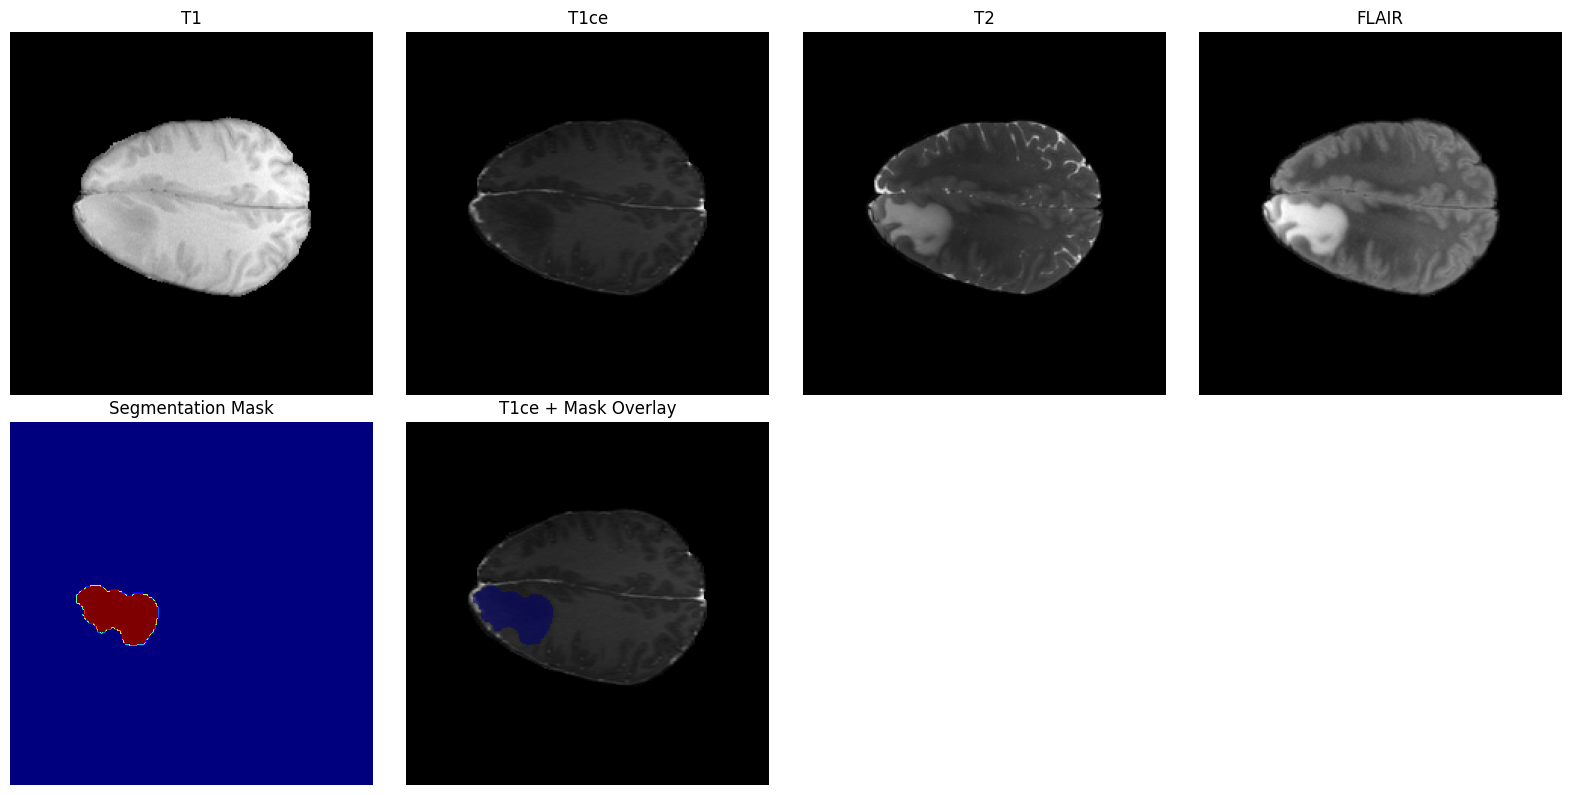

In [ ]:
# Visualizar un sample del dataset
def plot_dataset_sample(images, masks, idx=0):
    """Visualiza una muestra del dataset"""
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))

    # Mostrar modalidades
    modalities = ['T1', 'T1ce', 'T2', 'FLAIR']
    for i in range(4):
        axes[0, i].imshow(images[idx, i], cmap='gray')
        axes[0, i].set_title(f'{modalities[i]}')
        axes[0, i].axis('off')

    # Mostrar máscara
    axes[1, 0].imshow(masks[idx], cmap='jet')
    axes[1, 0].set_title('Segmentation Mask')
    axes[1, 0].axis('off')

    # Superponer máscara en T1ce
    axes[1, 1].imshow(images[idx, 1], cmap='gray')
    axes[1, 1].imshow(np.ma.masked_where(masks[idx] == 0, masks[idx]),
                      cmap='jet', alpha=0.5)
    axes[1, 1].set_title('T1ce + Mask Overlay')
    axes[1, 1].axis('off')

    # Ocultar axes restantes
    for i in range(2, 4):
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

print("\n🖼️ Visualizando muestra del dataset...")
plot_dataset_sample(images, masks)

In [ ]:
# 🎯 Funciones de pérdida y métricas para segmentación médica

class DiceLoss(nn.Module):
    """
    Implementación de Dice Loss para segmentación médica

    El Dice Loss es especialmente útil para segmentación porque:
    - Maneja bien el desbalance de clases (muy común en imágenes médicas)
    - Se enfoca en la superposición entre predicción y ground truth
    - Fórmula: Dice = 2 * |A ∩ B| / (|A| + |B|)

    Args:
        smooth: Factor de suavizado para evitar división por cero
    """
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, predictions, targets, num_classes=4):
        # Paso 1: Aplicar softmax para convertir logits a probabilidades
        # Las predicciones vienen como logits del modelo, necesitamos probabilidades
        predictions = F.softmax(predictions, dim=1)

        # Paso 2: Mapear valores de BraTS a clases consecutivas
        # BraTS usa: 0=background, 1=necrosis, 2=edema, 4=enhancing tumor
        # Necesitamos: 0=background, 1=necrosis, 2=edema, 3=enhancing tumor
        targets_mapped = targets.clone()
        targets_mapped[targets == 4] = 3  # Mapear enhancing tumor de 4 a 3

        # Asegurar que todos los valores estén en rango válido [0, 3]
        targets_mapped = torch.clamp(targets_mapped, 0, num_classes-1)

        # Paso 3: Convertir targets a one-hot encoding
        # Ejemplo: si tenemos clase 1, se convierte a [0, 1, 0, 0]
        targets_one_hot = F.one_hot(targets_mapped, num_classes=num_classes)
        # Reordenar dimensiones para que sea compatible: [batch, classes, height, width]
        targets_one_hot = targets_one_hot.permute(0, 3, 1, 2).float()

        # Paso 4: Calcular Dice Loss para cada clase y promediar
        dice_loss = 0
        for class_idx in range(num_classes):
            # Extraer predicciones y targets para esta clase específica
            pred_class = predictions[:, class_idx]
            target_class = targets_one_hot[:, class_idx]

            # Calcular intersección (píxeles correctamente predichos)
            intersection = (pred_class * target_class).sum()

            # Calcular coeficiente de Dice: 2*intersección / (pred + target)
            dice_coeff = (2.0 * intersection + self.smooth) / (
                pred_class.sum() + target_class.sum() + self.smooth
            )

            # Convertir a pérdida: 1 - dice_coefficient
            dice_loss += 1 - dice_coeff

        # Retornar pérdida promedio de todas las clases
        return dice_loss / num_classes

def dice_score(predictions, targets, num_classes=4):
    """
    Calcula el Dice Score (métrica de evaluación) para cada clase

    El Dice Score mide qué tan bien se superponen las predicciones con el ground truth.
    Rango: [0, 1] donde 1 es perfecto y 0 es completamente incorrecto.

    Args:
        predictions: Logits del modelo [batch_size, num_classes, height, width]
        targets: Ground truth masks [batch_size, height, width]
        num_classes: Número de clases (4 para BraTS)

    Returns:
        Lista con Dice Score para cada clase
    """
    # Paso 1: Obtener predicciones de clase tomando el argmax
    # Esto convierte probabilidades en predicciones discretas de clase
    pred_classes = torch.argmax(predictions, dim=1)

    # Paso 2: Mapear valores de BraTS igual que en DiceLoss
    targets_mapped = targets.clone()
    targets_mapped[targets == 4] = 3  # Mapear enhancing tumor de 4 a 3
    targets_mapped = torch.clamp(targets_mapped, 0, num_classes-1)

    # Paso 3: Calcular Dice Score para cada clase
    dice_scores = []
    for class_idx in range(num_classes):
        # Crear máscaras binarias para esta clase específica
        pred_mask = (pred_classes == class_idx).float()
        target_mask = (targets_mapped == class_idx).float()

        # Calcular intersección y unión
        intersection = (pred_mask * target_mask).sum()
        union = pred_mask.sum() + target_mask.sum()

        # Calcular Dice Score
        if union > 0:
            dice = (2.0 * intersection) / union
        else:
            # Si ambas máscaras están vacías, es un score perfecto
            dice = 1.0

        dice_scores.append(float(dice))

    return dice_scores

# 🔍 Verificación de prerequisitos antes del entrenamiento
print("🔍 Verificando que todos los componentes estén listos...")

# Verificar que el modelo U-Net está definido
if 'model' not in locals():
    print("❌ ERROR: El modelo no está definido!")
    print("📋 Para continuar, necesitas ejecutar primero las secciones anteriores:")
    print("   1. 📚 Importación de librerías")
    print("   2. 🏗️ Arquitectura U-Net")
    print("   3. ⚙️ Configuración del dispositivo")
    print("\n💡 Tip: Ejecuta las celdas en orden desde el principio del notebook")
    raise NameError("Variable 'model' no está definida")

# Verificar que el dispositivo está configurado
if 'device' not in locals():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"🔥 Configurando dispositivo: {device}")

# 🎛️ Configuración de hiperparámetros para el entrenamiento
print("\n🎛️ Configurando hiperparámetros de entrenamiento...")

# Learning rate: controla qué tan grandes son los pasos de optimización
learning_rate = 1e-4  # 0.0001 - valor conservador que funciona bien para segmentación

# Número de epochs: cuántas veces pasaremos por todo el dataset
num_epochs = 3  # Solo para demo - en práctica real usar 50-200+ epochs

# 🧠 Configuración del optimizador y funciones de pérdida
print("🧠 Inicializando optimizador y funciones de pérdida...")

# Adam optimizer: algoritmo de optimización adaptativa muy popular
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Funciones de pérdida que usaremos
dice_loss_fn = DiceLoss()  # Nuestra función personalizada para segmentación
ce_loss_fn = nn.CrossEntropyLoss()  # CrossEntropy estándar para clasificación

print("✅ ¡Todo configurado correctamente!")
print(f"📊 Learning rate: {learning_rate}")
print(f"🔄 Número de epochs: {num_epochs}")
print(f"🎯 Función de pérdida: Combinación de Dice Loss + CrossEntropy")
print(f"🚀 Optimizador: Adam")
print("\n🎓 Nota pedagógica:")
print("   - Usamos COMBINACIÓN de pérdidas para aprovechar lo mejor de ambas")
print("   - Dice Loss: excelente para desbalance de clases")
print("   - CrossEntropy: estabiliza el entrenamiento inicial")
print("   - Peso 50-50 entre ambas pérdidas")


✅ Funciones de pérdida y optimizer configurados!
📊 Learning rate: 0.0001
🔄 Número de epochs: 3


In [ ]:
# 🚀 Entrenamiento REAL de 3 épocas
def train_epoch(model, train_loader, optimizer, dice_loss_fn, ce_loss_fn, device, epoch):
    """
    🎓 FUNCIÓN DE ENTRENAMIENTO POR ÉPOCA

    Esta función entrena nuestro modelo U-Net durante UNA época completa.
    Una época = pasar por TODO el dataset de entrenamiento una vez.

    Parámetros:
    - model: nuestro modelo U-Net
    - train_loader: cargador de datos de entrenamiento
    - optimizer: optimizador Adam que ajusta los pesos
    - dice_loss_fn: función de pérdida Dice para segmentación
    - ce_loss_fn: función de pérdida CrossEntropy
    - device: GPU o CPU donde ejecutar
    - epoch: número de época actual (para mostrar progreso)
    """
    # 🏋️ Poner el modelo en modo entrenamiento
    # Esto activa dropout, batch normalization, etc.
    model.train()

    # 📊 Variables para acumular estadísticas
    total_loss = 0  # Suma de todas las pérdidas
    total_dice_scores = []  # Lista de puntajes Dice de cada batch

    print(f"\n📅 Epoch {epoch + 1} - Entrenamiento")
    print("-" * 40)

    # 🔄 BUCLE PRINCIPAL: procesar cada batch del dataset
    for batch_idx, (images, masks) in enumerate(train_loader):
        # 📥 PASO 1: Mover datos a GPU/CPU
        images = images.to(device)  # Imágenes MRI [batch_size, 4, 128, 128]
        masks = masks.to(device)   # Máscaras de segmentación [batch_size, 128, 128]

        # 🗂️ PASO 2: Mapear clases para CrossEntropyLoss
        # El dataset tiene clases [0,1,2,4] pero CrossEntropy espera [0,1,2,3]
        masks_mapped = masks.clone()  # Crear copia para no modificar original
        masks_mapped[masks == 4] = 3  # Cambiar clase 4 por clase 3
        masks_mapped = torch.clamp(masks_mapped, 0, 3)  # Asegurar rango [0-3]

        # 🧠 PASO 3: Forward pass (predicción)
        optimizer.zero_grad()  # Limpiar gradientes de iteración anterior
        outputs = model(images)  # Pasar imágenes por la red -> predicciones

        # 📏 PASO 4: Calcular pérdidas
        # Usamos COMBINACIÓN de dos pérdidas para mejor rendimiento
        dice_loss = dice_loss_fn(outputs, masks)  # Dice Loss (buena para desbalance)
        ce_loss = ce_loss_fn(outputs, masks_mapped)  # CrossEntropy (estabiliza)
        total_loss_batch = 0.5 * dice_loss + 0.5 * ce_loss  # Promedio 50-50

        # 🔄 PASO 5: Backward pass (aprendizaje)
        total_loss_batch.backward()  # Calcular gradientes
        optimizer.step()  # Actualizar pesos del modelo

        # 📊 PASO 6: Calcular métricas para monitoreo
        total_loss += total_loss_batch.item()  # Acumular pérdida
        batch_dice_scores = dice_score(outputs, masks)  # Calcular Dice Score
        total_dice_scores.append(batch_dice_scores)

        # 📺 PASO 7: Mostrar progreso cada cierto número de batches
        if batch_idx % max(1, len(train_loader) // 4) == 0:
            avg_dice = np.mean(batch_dice_scores)
            print(f"  Batch {batch_idx + 1}/{len(train_loader)}: "
                  f"Loss = {total_loss_batch.item():.4f}, "
                  f"Dice = {avg_dice:.4f}")

    # 📈 PASO 8: Calcular promedios finales de la época
    avg_loss = total_loss / len(train_loader)
    avg_dice_scores = np.mean(total_dice_scores, axis=0)

    return avg_loss, avg_dice_scores

def validate_epoch(model, val_loader, dice_loss_fn, ce_loss_fn, device, epoch):
    """
    🔍 FUNCIÓN DE VALIDACIÓN POR ÉPOCA

    Esta función evalúa qué tan bien funciona nuestro modelo entrenado
    en datos que NUNCA ha visto antes (conjunto de validación).

    Es crucial para detectar:
    - Overfitting: si el modelo memoriza en lugar de aprender
    - Underfitting: si el modelo no aprende lo suficiente

    Diferencias con entrenamiento:
    - NO se actualizan los pesos (no hay backward pass)
    - Se usa torch.no_grad() para ahorrar memoria
    - Modelo en modo evaluación (model.eval())
    """
    # 🔍 Poner modelo en modo evaluación
    # Esto desactiva dropout, batch normalization cambia comportamiento
    model.eval()

    # 📊 Variables para estadísticas
    total_loss = 0
    total_dice_scores = []

    print(f"\n🔍 Epoch {epoch + 1} - Validación")
    print("-" * 40)

    # 🚫 torch.no_grad(): NO calcular gradientes (ahorra memoria y tiempo)
    with torch.no_grad():
        for batch_idx, (images, masks) in enumerate(val_loader):
            # 📥 Mover datos a dispositivo
            images = images.to(device)
            masks = masks.to(device)

            # 🗂️ Mapear clases (igual que en entrenamiento)
            masks_mapped = masks.clone()
            masks_mapped[masks == 4] = 3
            masks_mapped = torch.clamp(masks_mapped, 0, 3)

            # 🧠 Forward pass SOLAMENTE (sin backward)
            outputs = model(images)

            # 📏 Calcular pérdidas (solo para monitoreo, no para aprender)
            dice_loss = dice_loss_fn(outputs, masks)
            ce_loss = ce_loss_fn(outputs, masks_mapped)
            total_loss_batch = 0.5 * dice_loss + 0.5 * ce_loss

            # 📊 Acumular estadísticas
            total_loss += total_loss_batch.item()
            batch_dice_scores = dice_score(outputs, masks)
            total_dice_scores.append(batch_dice_scores)

    # 📈 Calcular promedios
    avg_loss = total_loss / len(val_loader)
    avg_dice_scores = np.mean(total_dice_scores, axis=0)

    print(f"  Validación completada: Loss = {avg_loss:.4f}, "
          f"Dice = {np.mean(avg_dice_scores):.4f}")

    return avg_loss, avg_dice_scores

# 💾 Funciones para guardar modelo
def save_model(model, optimizer, epoch, loss, filename='brats_unet_express.pth'):
    """
    💾 FUNCIÓN PARA GUARDAR EL MODELO ENTRENADO

    Guarda el estado completo del modelo para poder:
    - Continuar entrenamiento más tarde
    - Usar el modelo para hacer predicciones
    - Compartir el modelo con otros

    Guarda:
    - Pesos del modelo (model_state_dict)
    - Estado del optimizador (optimizer_state_dict)
    - Número de época actual
    - Valor de la pérdida
    """
    torch.save({
        'epoch': epoch,  # Época en que se guardó
        'model_state_dict': model.state_dict(),  # Pesos de la red
        'optimizer_state_dict': optimizer.state_dict(),  # Estado del optimizador
        'loss': loss,  # Pérdida en el momento de guardar
    }, filename)
    print(f"💾 Modelo guardado en: {filename}")
    print(f"📄 Contiene: pesos del modelo, estado del optimizador, época {epoch}")


In [ ]:
# 🎯 FUNCIÓN PRINCIPAL DE ENTRENAMIENTO EXPRESS
def train_model_express():
    """
    🚀 FUNCIÓN PRINCIPAL DE ENTRENAMIENTO EXPRESS (3 ÉPOCAS)

    Esta función coordina todo el proceso de entrenamiento de nuestro modelo U-Net.
    - El entrenamiento en cada época
    - La validación del modelo
    - El seguimiento del progreso
    - El guardado del modelo final

    ¿Por qué solo 3 épocas?
    - Es un entrenamiento "express" para demostración
    - Permite ver resultados rápidamente
    - En proyectos reales usarías 50-200 épocas
    """
    print("🚀 Comenzando entrenamiento EXPRESS - 3 ÉPOCAS...")
    print("=" * 60)

    # 📊 HISTORIALES PARA SEGUIR EL PROGRESO
    # Estos arrays guardarán los resultados de cada época
    train_losses = []        # Pérdidas durante entrenamiento
    val_losses = []          # Pérdidas durante validación
    train_dice_history = []  # Dice scores del entrenamiento
    val_dice_history = []    # Dice scores de la validación

    # 🏷️ NOMBRES DE LAS CLASES QUE ESTAMOS SEGMENTANDO
    class_names = ['Background', 'NCR/NET', 'Edema', 'Enhancing']

    # 🔄 BUCLE PRINCIPAL DE ENTRENAMIENTO
    for epoch in range(3):  # Solo 3 épocas para entrenamiento express
        print(f"\n{'='*20} ÉPOCA {epoch + 1}/3 {'='*20}")

        # 🚂 FASE DE ENTRENAMIENTO
        # Aquí el modelo aprende de los datos de entrenamiento
        if len(train_loader) > 0:
            print("🚂 Iniciando fase de entrenamiento...")
            train_loss, train_dice = train_epoch(
                model, train_loader, optimizer, dice_loss_fn, ce_loss_fn, device, epoch
            )
            train_losses.append(train_loss)
            train_dice_history.append(train_dice)
            print(f"✅ Entrenamiento completado - Loss: {train_loss:.4f}")
        else:
            print("⚠️ No hay datos de entrenamiento disponibles")
            continue

        # 🔍 FASE DE VALIDACIÓN
        # Aquí evaluamos qué tan bien funciona el modelo en datos que NO ha visto
        if len(val_loader) > 0:
            print("🔍 Iniciando fase de validación...")
            val_loss, val_dice = validate_epoch(
                model, val_loader, dice_loss_fn, ce_loss_fn, device, epoch
            )
            val_losses.append(val_loss)
            val_dice_history.append(val_dice)
            print(f"✅ Validación completada - Loss: {val_loss:.4f}")
        else:
            print("⚠️ No hay datos de validación - usando métricas de entrenamiento")
            val_loss, val_dice = train_loss, train_dice
            val_losses.append(val_loss)
            val_dice_history.append(val_dice)

        # 📊 RESUMEN DETALLADO DE LA ÉPOCA
        print(f"\n📊 RESUMEN ÉPOCA {epoch + 1}:")
        print(f"  🚂 Entrenamiento - Loss: {train_loss:.4f}")
        print(f"  🔍 Validación    - Loss: {val_loss:.4f}")
        print(f"  📈 Dice Scores por clase:")

        # Mostrar el rendimiento para cada tipo de tumor
        for i, (name, train_d, val_d) in enumerate(zip(class_names, train_dice, val_dice)):
            print(f"    {name:12}: Train {train_d:.4f} | Val {val_d:.4f}")

        # Promedio general de todas las clases
        avg_train_dice = np.mean(train_dice)
        avg_val_dice = np.mean(val_dice)
        print(f"  📊 Dice Promedio: Train {avg_train_dice:.4f} | Val {avg_val_dice:.4f}")

        # 🚨 ANÁLISIS DEL PROGRESO
        if epoch > 0:
            train_improvement = train_losses[epoch] - train_losses[epoch-1]
            val_improvement = val_losses[epoch] - val_losses[epoch-1]

            if train_improvement < 0:
                print(f"  📈 Mejora en entrenamiento: {abs(train_improvement):.4f}")
            else:
                print(f"  📉 Empeoramiento en entrenamiento: {train_improvement:.4f}")

            if val_improvement < 0:
                print(f"  📈 Mejora en validación: {abs(val_improvement):.4f}")
            else:
                print(f"  📉 Empeoramiento en validación: {val_improvement:.4f}")

    print("\n🎉 ¡ENTRENAMIENTO EXPRESS COMPLETADO!")
    print("=" * 60)

    # 💾 GUARDAR EL MODELO ENTRENADO
    if train_losses:
        final_loss = val_losses[-1] if val_losses else train_losses[-1]
        print(f"💾 Guardando modelo con loss final: {final_loss:.4f}")
        save_model(model, optimizer, 3, final_loss)

    # 📋 RESUMEN FINAL
    print(f"\n📋 RESUMEN FINAL DEL ENTRENAMIENTO:")
    print(f"  🏁 Épocas completadas: 3")
    print(f"  📊 Loss inicial: {train_losses[0]:.4f}")
    print(f"  📊 Loss final: {train_losses[-1]:.4f}")
    print(f"  📈 Mejora total: {train_losses[0] - train_losses[-1]:.4f}")

    # 🔄 DEVOLVER TODOS LOS RESULTADOS PARA ANÁLISIS POSTERIOR
    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_dice_history': train_dice_history,
        'val_dice_history': val_dice_history
    }

# 🏃‍♂️ EJECUTAR EL ENTRENAMIENTO EXPRESS
print("🎓 ESTUDIANTES: ¡Observen cómo el modelo aprende en tiempo real!")
print("📚 Verán cómo mejoran las métricas época tras época")
print("🔍 Presten atención a:")
print("   - Cómo bajan las pérdidas (loss)")
print("   - Cómo suben los Dice scores")
print("   - Las diferencias entre entrenamiento y validación")
print("\n🚀 ¡Comenzando en 3... 2... 1...!")

training_history = train_model_express()

print("📊 Los resultados están guardados en 'training_history' para análisis")


🚀 Comenzando entrenamiento EXPRESS - 3 ÉPOCAS...

==================== ÉPOCA 1/3 ====================

📅 Epoch 1 - Entrenamiento
----------------------------------------
  Batch 1/127: Loss = 1.0514, Dice = 0.1969
  Batch 32/127: Loss = 0.6948, Dice = 0.8091
  Batch 63/127: Loss = 0.6847, Dice = 0.6872
  Batch 94/127: Loss = 0.6108, Dice = 0.5755
  Batch 125/127: Loss = 0.5676, Dice = 0.8721

🔍 Epoch 1 - Validación
----------------------------------------
  Validación completada: Loss = 0.5736, Dice = 0.6382

📊 RESUMEN ÉPOCA 1:
  🚂 Train - Loss: 0.6634
  🔍 Val   - Loss: 0.5736
  📈 Dice Scores por clase:
    Background  : Train 0.9896 | Val 0.9956
    NCR/NET     : Train 0.6957 | Val 0.1113
    Edema       : Train 0.7189 | Val 0.7507
    Enhancing   : Train 0.6645 | Val 0.6951
  📊 Dice Promedio: Train 0.7672 | Val 0.6382

==================== ÉPOCA 2/3 ====================

📅 Epoch 2 - Entrenamiento
----------------------------------------
  Batch 1/127: Loss = 0.5308, Dice = 0.9071
  B

In [ ]:
# 🔮 FUNCIONES DE INFERENCIA Y EVALUACIÓN
# ===============================================
# 🎓 ESTUDIANTES: Esta sección contiene las herramientas para evaluar
# qué tan bien funciona nuestro modelo después del entrenamiento

def comprehensive_evaluation(model, dataloader, device):
    """
    🧠 EVALUACIÓN COMPREHENSIVA DEL MODELO

    Esta función realiza una evaluación completa del modelo entrenado:
    1. 🔍 Procesa todo el dataset de validación/test
    2. 📊 Calcula métricas de rendimiento (Dice Score)
    3. 💾 Guarda ejemplos de predicciones para visualización
    4. 📈 Retorna estadísticas resumidas

    Args:
        model: El modelo U-Net entrenado
        dataloader: DataLoader con imágenes para evaluar
        device: GPU o CPU donde ejecutar las predicciones

    Returns:
        dict: Diccionario con métricas y ejemplos de predicciones
    """
    # 🔧 CONFIGURAR MODELO EN MODO EVALUACIÓN
    # Esto desactiva dropout y batch normalization
    model.eval()

    # 📦 CONTENEDORES PARA GUARDAR RESULTADOS
    all_dice_scores = []      # 📊 Todos los Dice scores calculados
    all_predictions = []      # 🎯 Predicciones del modelo (solo algunos ejemplos)
    all_targets = []          # 🎯 Máscaras verdaderas (ground truth)

    print("🔍 Evaluando modelo en dataset completo...")
    print("📚 ESTUDIANTES: Observen cómo el modelo predice cada imagen")

    # 🚫 DESACTIVAR CÁLCULO DE GRADIENTES
    # Durante evaluación NO necesitamos gradientes (solo predicciones)
    with torch.no_grad():
        # 🔄 PROCESAR CADA BATCH DE IMÁGENES
        for batch_idx, (images, masks) in enumerate(dataloader):
            # 📍 MOVER DATOS A DISPOSITIVO (GPU/CPU)
            images = images.to(device)
            masks = masks.to(device)

            # 🧠 REALIZAR PREDICCIÓN
            # El modelo devuelve probabilidades para cada clase
            outputs = model(images)

            # 🎯 CONVERTIR PROBABILIDADES A PREDICCIONES FINALES
            # argmax encuentra la clase con mayor probabilidad
            predicted_masks = torch.argmax(outputs, dim=1)

            # 📊 CALCULAR MÉTRICAS PARA CADA IMAGEN EN EL BATCH
            for i in range(images.shape[0]):
                # 🔄 MOVER RESULTADOS A CPU PARA PROCESAMIENTO
                pred_mask = predicted_masks[i].cpu().numpy()
                true_mask = masks[i].cpu().numpy()

                # 🎯 CALCULAR DICE SCORE
                # Esta es nuestra métrica principal de precisión
                dice_scores = dice_score(outputs[i:i+1], masks[i:i+1])
                all_dice_scores.append(dice_scores)

                # 💾 GUARDAR EJEMPLOS PARA VISUALIZACIÓN POSTERIOR
                # Solo guardamos los primeros 5 para no consumir mucha memoria
                if len(all_predictions) < 5:  # Solo guardar algunos ejemplos
                    all_predictions.append(pred_mask)
                    all_targets.append(true_mask)

    # 📊 CALCULAR MÉTRICAS PROMEDIO
    # Promediamos todos los Dice scores para obtener el rendimiento general
    avg_dice_scores = np.mean(all_dice_scores, axis=0)

    print("✅ ¡Evaluación completada!")
    print(f"📊 Se evaluaron {len(all_dice_scores)} imágenes")
    print(f"🎯 Dice Score promedio: {np.mean(avg_dice_scores):.4f}")

    # 📋 RETORNAR RESULTADOS ORGANIZADOS
    return {
        'dice_scores': avg_dice_scores,     # 📊 Métricas promedio por clase
        'predictions': all_predictions,     # 🎯 Ejemplos de predicciones
        'targets': all_targets             # 🎯 Máscaras verdaderas correspondientes
    }


📈 Visualizando curvas de entrenamiento...


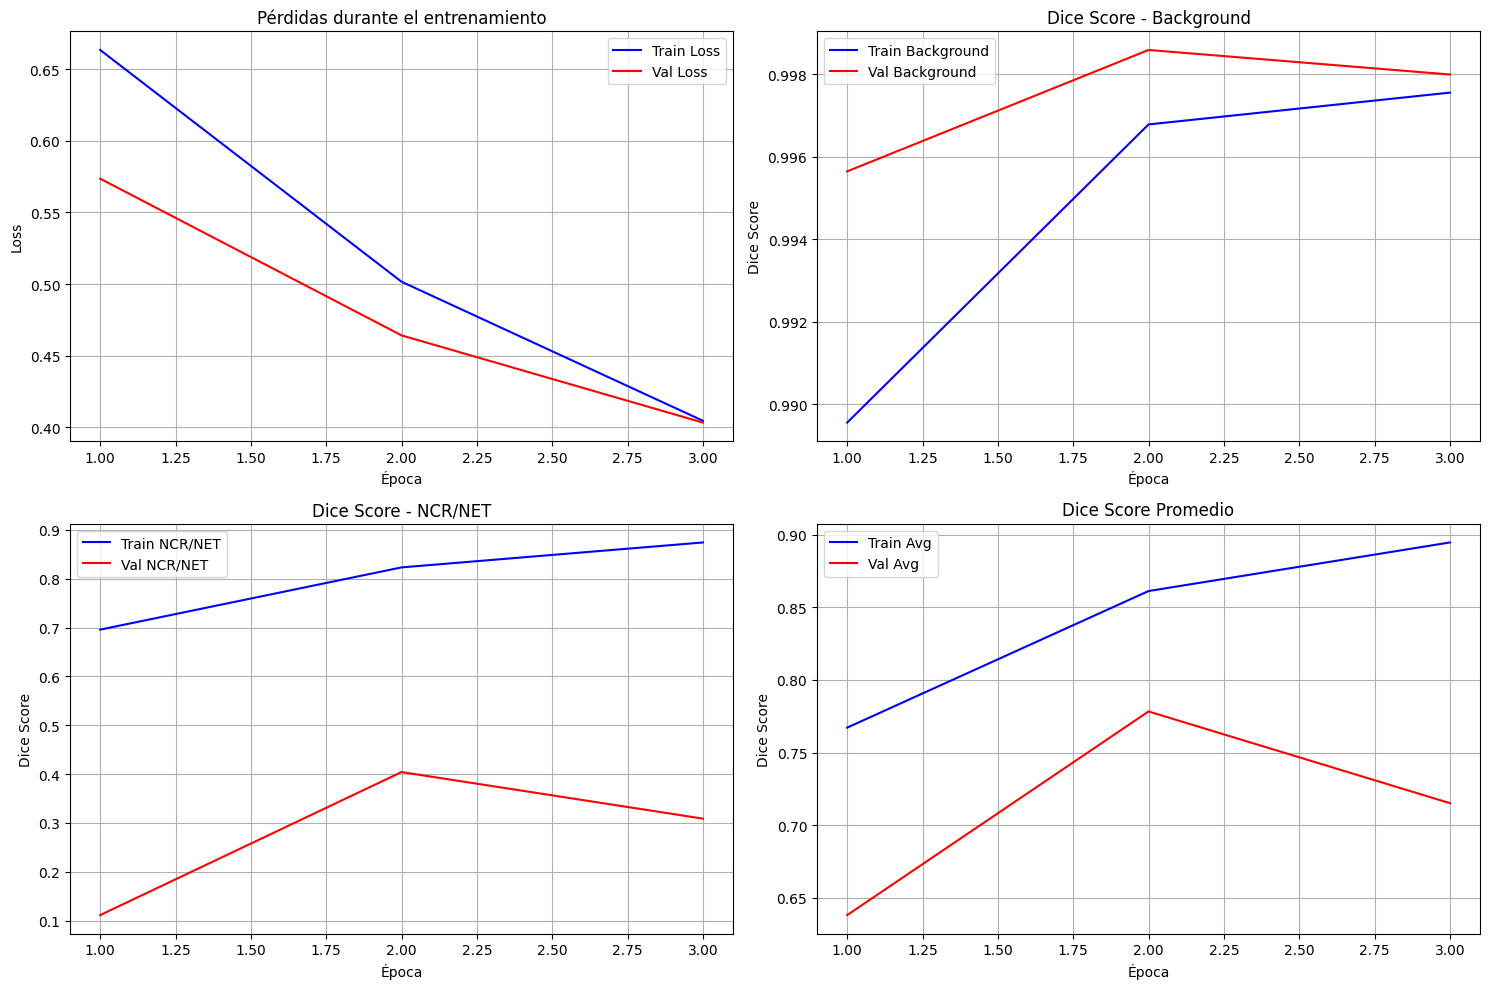


📊 Ejecutando evaluación final en conjunto de test...
🔍 Evaluando modelo en dataset completo...


In [ ]:
# 📈 VISUALIZACIÓN DE CURVAS DE ENTRENAMIENTO
# ============================================
# Esta función nos ayuda a entender cómo se comportó nuestro modelo durante el entrenamiento

def plot_training_curves(history):
    """
    📊 Visualiza las curvas de entrenamiento para analizar el rendimiento del modelo

    ¿Qué nos muestran estas gráficas?
    - 📉 Si el modelo está aprendiendo correctamente
    - 🎯 Si hay overfitting (sobreajuste)
    - 📈 Qué tan bien generaliza a datos nuevos
    """
    # ⚠️ VERIFICAR QUE TENEMOS DATOS PARA GRAFICAR
    if not history['train_losses']:
        print("⚠️ No hay datos de entrenamiento para visualizar")
        return

    # 📅 CREAR LISTA DE ÉPOCAS (1, 2, 3, ...)
    epochs = range(1, len(history['train_losses']) + 1)

    # 🖼️ CREAR FIGURA CON 4 SUBGRÁFICAS (2x2)
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # 📉 GRÁFICA 1: PÉRDIDAS (LOSSES)
    # Esta gráfica nos muestra si el modelo está aprendiendo
    # - Si baja = ✅ el modelo mejora
    # - Si sube = ❌ el modelo empeora
    axes[0, 0].plot(epochs, history['train_losses'], 'b-', label='Pérdida Entrenamiento', linewidth=2)
    axes[0, 0].plot(epochs, history['val_losses'], 'r-', label='Pérdida Validación', linewidth=2)
    axes[0, 0].set_title('📉 Evolución de las Pérdidas', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Época (iteración completa del dataset)')
    axes[0, 0].set_ylabel('Valor de la Pérdida')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # 🏷️ NOMBRES DE LAS CLASES QUE ESTAMOS SEGMENTANDO
    class_names = ['Background', 'NCR/NET', 'Edema', 'Enhancing']

    # 📊 CONVERTIR HISTORIAL A ARRAYS PARA FACILITAR MANEJO
    train_dice = np.array(history['train_dice_history'])
    val_dice = np.array(history['val_dice_history'])

    # 🎯 GRÁFICA 2: DICE SCORE PARA BACKGROUND
    # El Dice Score mide qué tan bien segmentamos cada clase
    # - Valor cerca de 1.0 = ✅ Excelente segmentación
    # - Valor cerca de 0.0 = ❌ Mala segmentación
    axes[0, 1].plot(epochs, train_dice[:, 0], 'b-', label='Train Background', linewidth=2)
    axes[0, 1].plot(epochs, val_dice[:, 0], 'r-', label='Val Background', linewidth=2)
    axes[0, 1].set_title('🎯 Dice Score - Background\n(Fondo/No-tumor)', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Época')
    axes[0, 1].set_ylabel('Dice Score (0-1)')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].set_ylim([0, 1])  # Establecer límites del eje Y

    # 🧠 GRÁFICA 3: DICE SCORE PARA NCR/NET
    # NCR/NET = Núcleo necrótico y tejido no potenciado
    # Es una de las partes más importantes del tumor
    axes[1, 0].plot(epochs, train_dice[:, 1], 'b-', label='Train NCR/NET', linewidth=2)
    axes[1, 0].plot(epochs, val_dice[:, 1], 'r-', label='Val NCR/NET', linewidth=2)
    axes[1, 0].set_title('🧠 Dice Score - NCR/NET\n(Núcleo del tumor)', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Época')
    axes[1, 0].set_ylabel('Dice Score (0-1)')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].set_ylim([0, 1])

    # 📊 GRÁFICA 4: DICE SCORE PROMEDIO
    # Esta es la métrica más importante: el rendimiento general
    # ¡Esta es la que más nos importa para evaluar nuestro modelo!
    avg_train_dice = np.mean(train_dice, axis=1)
    avg_val_dice = np.mean(val_dice, axis=1)
    axes[1, 1].plot(epochs, avg_train_dice, 'b-', label='Entrenamiento', linewidth=3)
    axes[1, 1].plot(epochs, avg_val_dice, 'r-', label='Validación', linewidth=3)
    axes[1, 1].set_title('⭐ Dice Score PROMEDIO\n(Rendimiento General)', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Época')
    axes[1, 1].set_ylabel('Dice Score Promedio (0-1)')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].set_ylim([0, 1])

    # 🎨 MEJORAR APARIENCIA GENERAL
    plt.tight_layout()
    plt.show()

    # 📝 EXPLICACIÓN PARA ESTUDIANTES
    print("📚 CÓMO INTERPRETAR ESTAS GRÁFICAS:")
    print("="*50)
    print("🔵 Línea Azul = Datos de ENTRENAMIENTO (lo que el modelo 'estudió')")
    print("🔴 Línea Roja = Datos de VALIDACIÓN (datos 'nuevos' que el modelo no vio)")
    print()
    print("✅ SEÑALES BUENAS:")
    print("   • Ambas líneas bajan juntas en pérdidas")
    print("   • Ambas líneas suben juntas en Dice Score")
    print("   • Las líneas están cerca una de la otra")
    print()
    print("⚠️ SEÑALES DE OVERFITTING:")
    print("   • Línea azul mejora pero roja empeora")
    print("   • Gran separación entre las líneas")
    print()

print("📈 Visualizando curvas de entrenamiento...")
print("💡 Esto nos ayudará a entender qué tan bien aprendió nuestro modelo")
plot_training_curves(training_history)

# 🧪 EVALUACIÓN FINAL DEL MODELO
# ==============================
# Ahora vamos a probar nuestro modelo entrenado con datos completamente nuevos

print("\n" + "="*60)
print("🧪 INICIANDO EVALUACIÓN FINAL DEL MODELO")
print("="*60)
print("💡 Esto es como el 'examen final' de nuestro modelo")
print("📚 Usaremos datos que el modelo NUNCA vio durante el entrenamiento")

# 🎯 DECIDIR QUÉ CONJUNTO DE DATOS USAR
if len(test_loader) > 0:
    print("✅ Usando conjunto de TEST (datos completamente nuevos)")
    evaluation_results = comprehensive_evaluation(model, test_loader, device)
    dataset_name = "Test"
else:
    print("⚠️ No hay conjunto de test disponible")
    print("📊 Evaluando en conjunto de VALIDACIÓN como alternativa")
    evaluation_results = comprehensive_evaluation(model, val_loader, device)
    dataset_name = "Validación"

print(f"🎯 Evaluación completada en conjunto de {dataset_name}")

In [ ]:
# 📊 MOSTRAR RESULTADOS DE EVALUACIÓN
# ==================================
# Ahora vamos a interpretar los resultados que obtuvo nuestro modelo

# 🏷️ Definir nombres de las clases para que sea más fácil entender
class_names = ['Background', 'NCR/NET', 'Edema', 'Enhancing']

print(f"\n📈 RESULTADOS DE EVALUACIÓN - {dataset_name.upper()}")
print("=" * 60)
print("💡 Estos números nos dicen qué tan bien nuestro modelo puede identificar cada tipo de tejido")

print("\n🎯 Dice Scores por clase:")
print("📚 (El Dice Score va de 0 a 1, donde 1 = perfecto, 0 = terrible)")
for i, (name, score) in enumerate(zip(class_names, evaluation_results['dice_scores'])):
    # 🎨 Agregar indicadores visuales de qué tan bueno es el score
    if score >= 0.8:
        indicator = "🟢 Excelente"
    elif score >= 0.6:
        indicator = "🟡 Bueno"
    elif score >= 0.4:
        indicator = "🟠 Regular"
    else:
        indicator = "🔴 Necesita mejorar"

    print(f"  {name:12}: {score:.4f} {indicator}")

# 📊 Calcular y mostrar el promedio general
average_dice = np.mean(evaluation_results['dice_scores'])
print(f"\n  📊 Dice Score promedio: {average_dice:.4f}")

# 🎓 Explicación educativa del resultado promedio
print(f"\n🎓 INTERPRETACIÓN DEL RESULTADO PROMEDIO:")
if average_dice >= 0.8:
    print("   🌟 ¡EXCELENTE! El modelo funciona muy bien")
elif average_dice >= 0.6:
    print("   ✅ BUENO: El modelo tiene un rendimiento aceptable")
elif average_dice >= 0.4:
    print("   ⚠️ REGULAR: El modelo necesita más entrenamiento")
else:
    print("   ❌ BAJO: El modelo necesita ajustes importantes")

print(f"\n✅ Evaluación en conjunto de {dataset_name} completada!")
print("🔍 A continuación veremos ejemplos visuales de las predicciones...")



📈 RESULTADOS DE EVALUACIÓN - TEST
💡 Estos números nos dicen qué tan bien nuestro modelo puede identificar cada tipo de tejido

🎯 Dice Scores por clase:
📚 (El Dice Score va de 0 a 1, donde 1 = perfecto, 0 = terrible)
  Background  : 0.9978 🟢 Excelente
  NCR/NET     : 0.5211 🟠 Regular
  Edema       : 0.5564 🟠 Regular
  Enhancing   : 0.6713 🟡 Bueno

  📊 Dice Score promedio: 0.6867

🎓 INTERPRETACIÓN DEL RESULTADO PROMEDIO:
   ✅ BUENO: El modelo tiene un rendimiento aceptable

✅ Evaluación en conjunto de Test completada!
🔍 A continuación veremos ejemplos visuales de las predicciones...


🎬 COMENZANDO ANÁLISIS VISUAL DE PREDICCIONES...

📚 Analizaremos 2 ejemplos para entender el comportamiento del modelo:

========================= 📋 EJEMPLO 1 DE 2 =========================

🔬 Analizando muestra 1...
💡 Tip: Fíjate en las diferencias entre la predicción y el ground truth
   📡 Modalidades MRI originales:
      • T1: Anatomía básica
      • T1ce: Con contraste (tumores brillantes)
      • T2: Detecta fluidos/edema
      • FLAIR: Suprime fluido normal
   🏷️ Comparación de segmentaciones:
      • Ground Truth: La segmentación correcta hecha por expertos
      • Predicción: Lo que nuestro modelo cree que es cada región
      • Diferencias: Las zonas rojas son donde el modelo se equivocó
      • Overlay: La predicción superpuesta sobre la imagen original


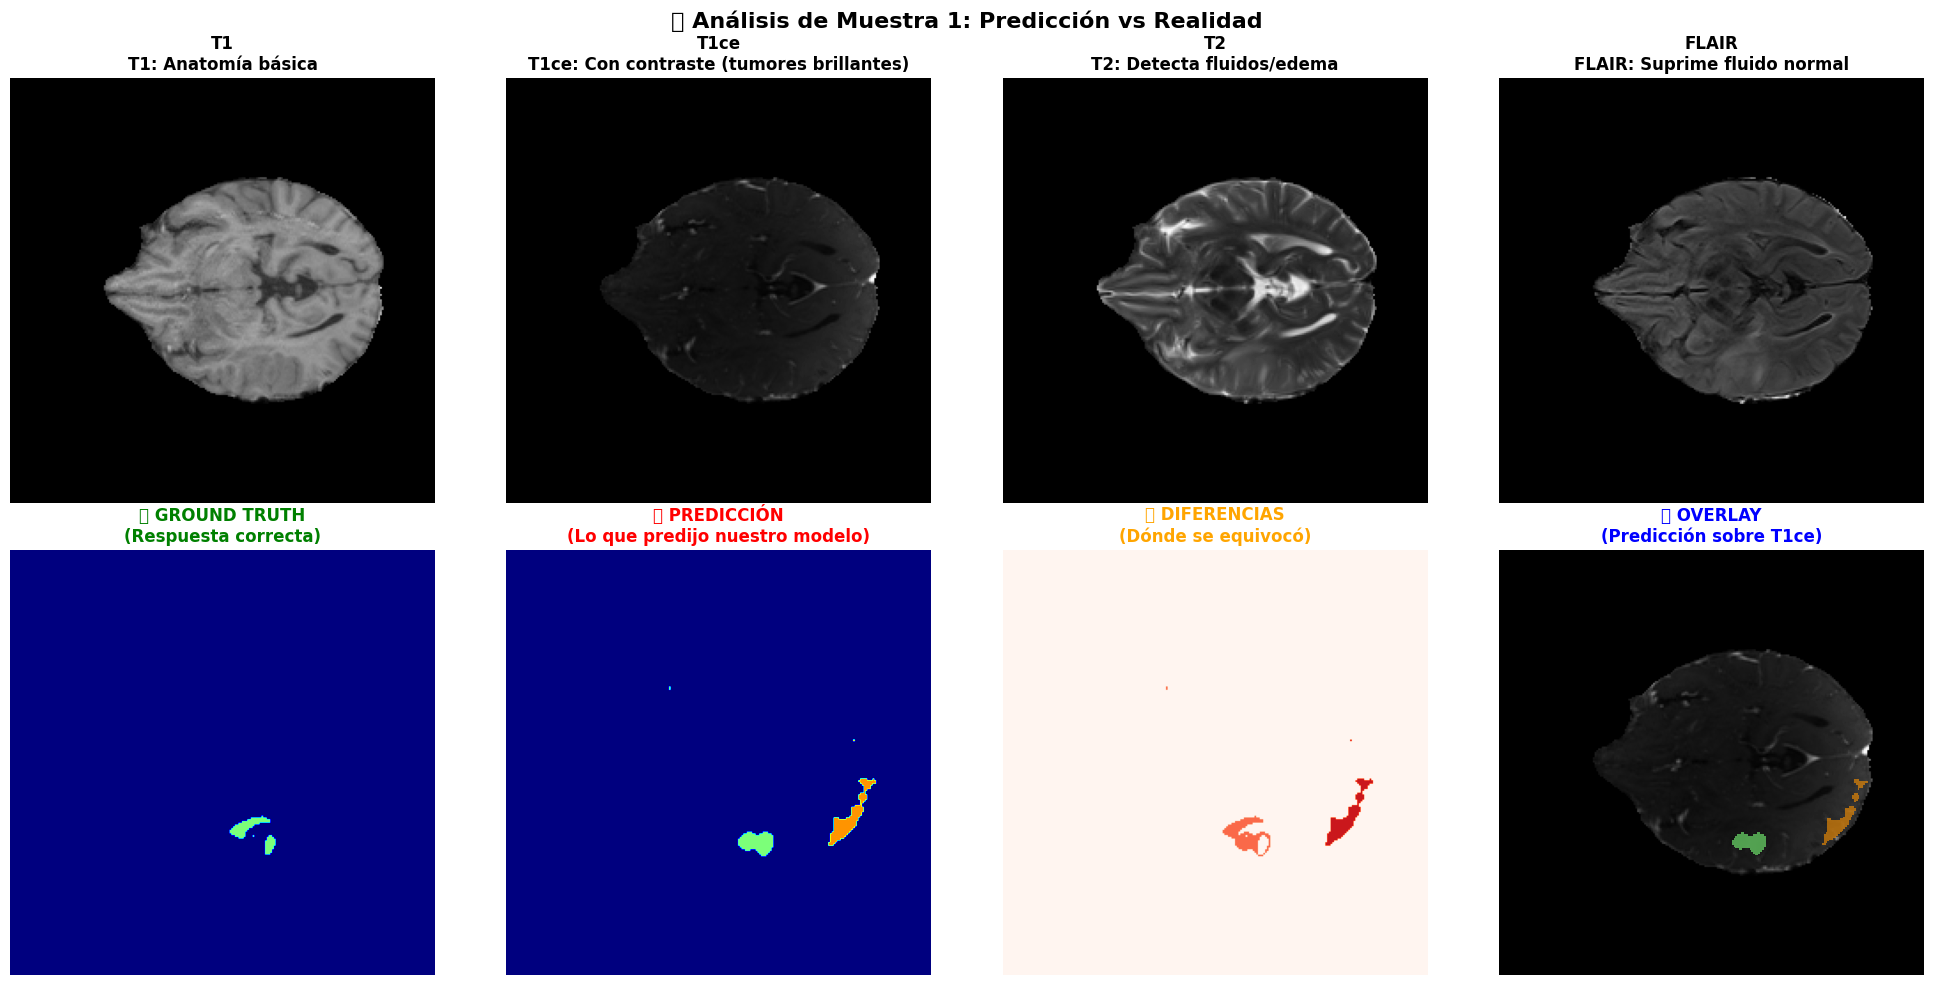


📊 Calculando métricas detalladas para esta muestra...
   🧮 Dice Score por clase (0 = malo, 1 = perfecto):

📈 MÉTRICAS DETALLADAS PARA MUESTRA 1:
--------------------------------------------------
   Background   (Fondo (tejido normal)): 0.9954
   NCR/NET      (Núcleo necrótico (tumor muerto)): 1.0000
   Edema        (Edema (hinchazón)   ): 0.2742
   Enhancing    (Tumor activo (peligroso)): 0.0000

   🎯 DICE PROMEDIO: 0.5674

⏳ Preparando siguiente ejemplo...

========================= 📋 EJEMPLO 2 DE 2 =========================

🔬 Analizando muestra 2...
💡 Tip: Fíjate en las diferencias entre la predicción y el ground truth
   📡 Modalidades MRI originales:
      • T1: Anatomía básica
      • T1ce: Con contraste (tumores brillantes)
      • T2: Detecta fluidos/edema
      • FLAIR: Suprime fluido normal
   🏷️ Comparación de segmentaciones:
      • Ground Truth: La segmentación correcta hecha por expertos
      • Predicción: Lo que nuestro modelo cree que es cada región
      • Diferencia

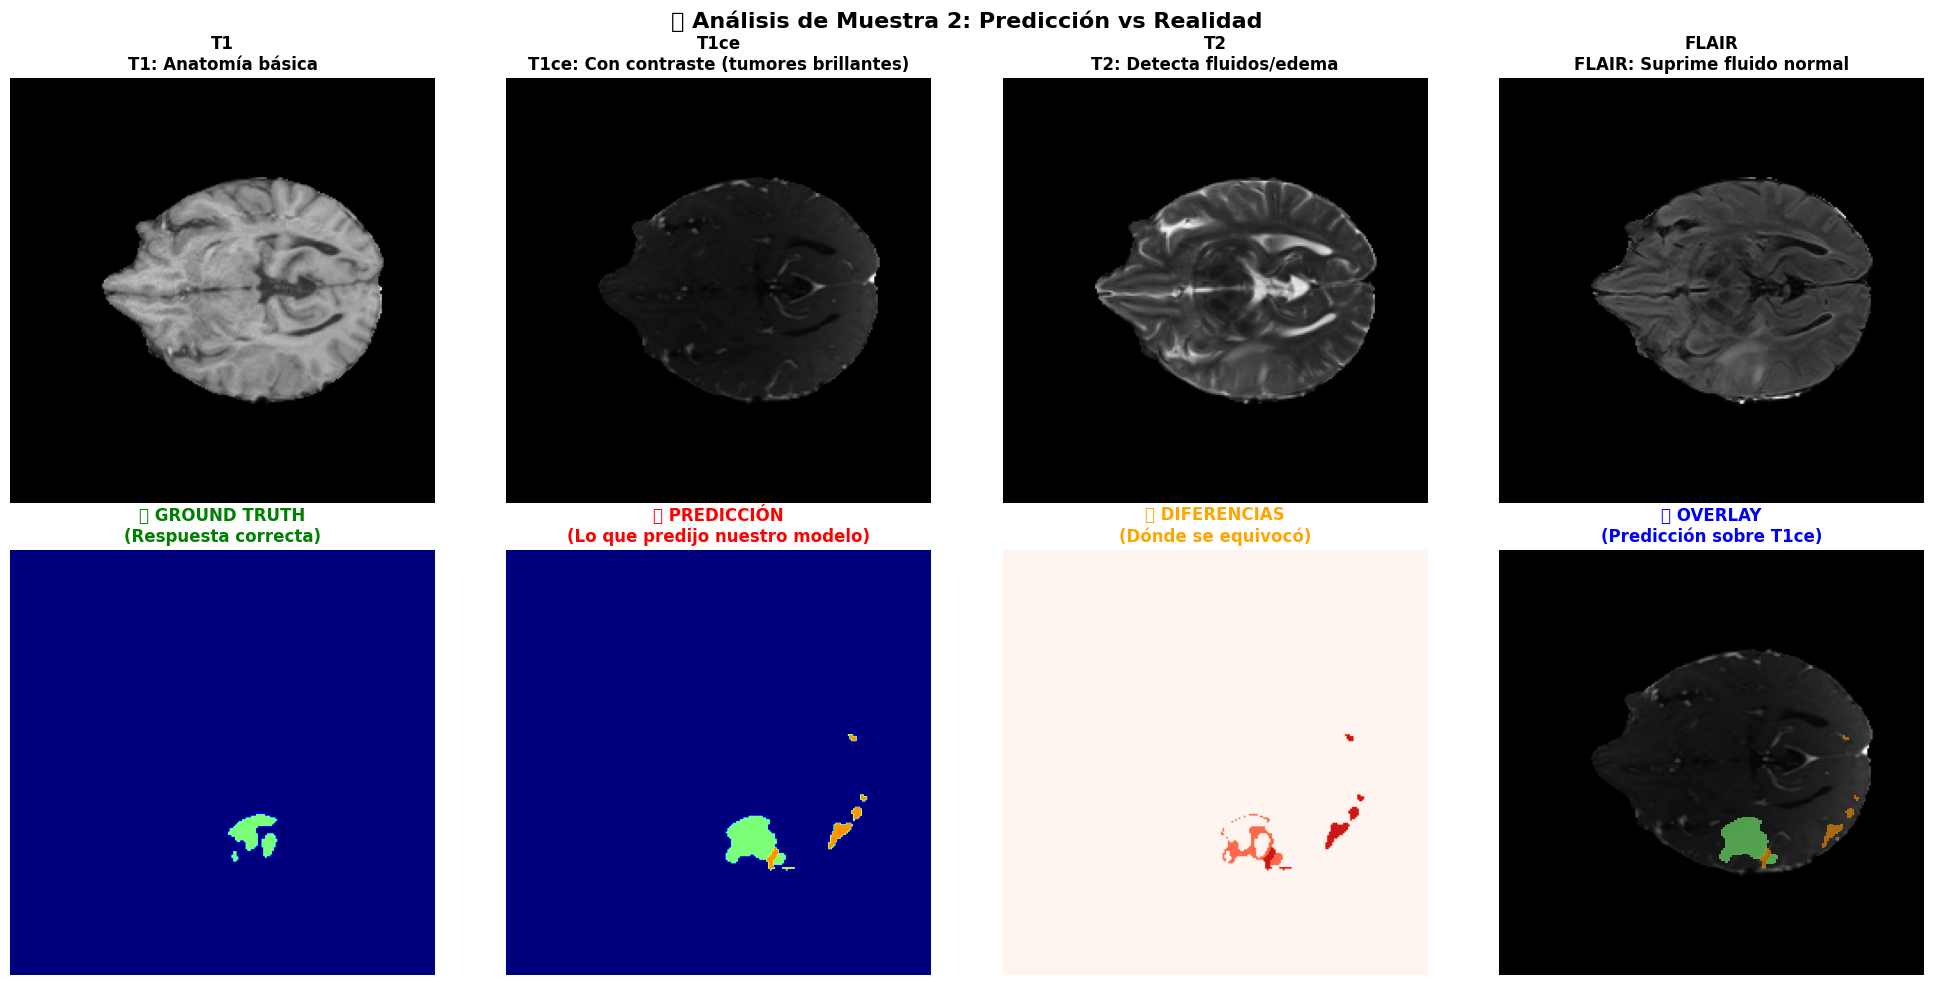


📊 Calculando métricas detalladas para esta muestra...
   🧮 Dice Score por clase (0 = malo, 1 = perfecto):

📈 MÉTRICAS DETALLADAS PARA MUESTRA 2:
--------------------------------------------------
   Background   (Fondo (tejido normal)): 0.9958
   NCR/NET      (Núcleo necrótico (tumor muerto)): 1.0000
   Edema        (Edema (hinchazón)   ): 0.7216
   Enhancing    (Tumor activo (peligroso)): 0.0000

   🎯 DICE PROMEDIO: 0.6794

🎯 📚 RESUMEN FINAL DEL ENTRENAMIENTO EXPRESS 📚 🎯
🎓 ¡Felicidades! Has completado tu primer entrenamiento de segmentación médica

📊 CONFIGURACIÓN DE TU EXPERIMENTO:
   🗂️  Dataset: 25 casos BraTS reales de pacientes
   📂 Split: 20 entrenamiento / 3 validación / 2 prueba
   ⏱️  Épocas: 3 (entrenamiento express para aprender rápido)
   🧠 Arquitectura: U-Net con 17,263,748 parámetros neuronales
   📦 Batch size: 6 casos por vez

📈 PROGRESO DE APRENDIZAJE:
   📉 Loss inicial: 0.6634 (el modelo empezó confundido)
   📈 Loss final:   0.4047 (el modelo aprendió)
   🚀 Mejora to

In [ ]:
# 📸 VISUALIZACIÓN DE PREDICCIONES VS GROUND TRUTH
# ================================================
# 🎓 Esta sección es SÚPER IMPORTANTE para entender cómo funciona nuestro modelo
# Aquí vamos a ver las imágenes reales y compararlas con lo que predijo nuestro modelo

def plot_prediction_comparison(images, predictions, targets, sample_idx=0):
    """
    🔍 Esta función visualiza las diferencias entre lo que predijo nuestro modelo
    y la respuesta correcta (ground truth)

    📚 ¿Qué hace exactamente?
    1. Muestra las 4 modalidades de MRI originales
    2. Muestra la segmentación correcta (ground truth)
    3. Muestra lo que predijo nuestro modelo
    4. Calcula las diferencias entre ambas
    """
    print(f"\n🔬 Analizando muestra {sample_idx + 1}...")
    print("💡 Tip: Fíjate en las diferencias entre la predicción y el ground truth")

    # Obtener una muestra del dataset para las imágenes
    current_loader = test_loader if len(test_loader) > 0 else val_loader
    sample_batch = next(iter(current_loader))
    sample_images = sample_batch[0]

    if sample_idx < len(predictions):
        pred_mask = predictions[sample_idx]
        true_mask = targets[sample_idx]

        # Usar imagen correspondiente
        if sample_idx < len(sample_images):
            image_slice = sample_images[sample_idx]
        else:
            image_slice = sample_images[0]  # Fallback

        # 🎨 Crear una visualización grande y clara
        fig, axes = plt.subplots(2, 4, figsize=(20, 10))
        fig.suptitle(f'🧠 Análisis de Muestra {sample_idx + 1}: Predicción vs Realidad',
                    fontsize=16, fontweight='bold')

        # 📡 FILA SUPERIOR: Las 4 modalidades originales de MRI
        print("   📡 Modalidades MRI originales:")
        modalities = ['T1', 'T1ce', 'T2', 'FLAIR']
        modality_descriptions = [
            'T1: Anatomía básica',
            'T1ce: Con contraste (tumores brillantes)',
            'T2: Detecta fluidos/edema',
            'FLAIR: Suprime fluido normal'
        ]

        for i in range(4):
            axes[0, i].imshow(image_slice[i], cmap='gray')
            axes[0, i].set_title(f'{modalities[i]}\n{modality_descriptions[i]}',
                               fontsize=12, fontweight='bold')
            axes[0, i].axis('off')
            print(f"      • {modality_descriptions[i]}")

        # 🏷️ FILA INFERIOR: Comparación de segmentaciones
        print("   🏷️ Comparación de segmentaciones:")

        # Ground Truth (la respuesta correcta)
        axes[1, 0].imshow(true_mask, cmap='jet', vmin=0, vmax=4)
        axes[1, 0].set_title('✅ GROUND TRUTH\n(Respuesta correcta)',
                           fontsize=12, fontweight='bold', color='green')
        axes[1, 0].axis('off')
        print("      • Ground Truth: La segmentación correcta hecha por expertos")

        # Predicción del modelo
        axes[1, 1].imshow(pred_mask, cmap='jet', vmin=0, vmax=4)
        axes[1, 1].set_title('🤖 PREDICCIÓN\n(Lo que predijo nuestro modelo)',
                           fontsize=12, fontweight='bold', color='red')
        axes[1, 1].axis('off')
        print("      • Predicción: Lo que nuestro modelo cree que es cada región")

        # Mapa de diferencias
        diff_mask = np.abs(pred_mask.astype(int) - true_mask.astype(int))
        axes[1, 2].imshow(diff_mask, cmap='Reds', vmin=0, vmax=4)
        axes[1, 2].set_title('❌ DIFERENCIAS\n(Dónde se equivocó)',
                           fontsize=12, fontweight='bold', color='orange')
        axes[1, 2].axis('off')
        print("      • Diferencias: Las zonas rojas son donde el modelo se equivocó")

        # Superposición en T1ce (la más informativa)
        axes[1, 3].imshow(image_slice[1], cmap='gray')
        axes[1, 3].imshow(np.ma.masked_where(pred_mask == 0, pred_mask),
                         cmap='jet', alpha=0.6, vmin=0, vmax=4)
        axes[1, 3].set_title('🎯 OVERLAY\n(Predicción sobre T1ce)',
                           fontsize=12, fontweight='bold', color='blue')
        axes[1, 3].axis('off')
        print("      • Overlay: La predicción superpuesta sobre la imagen original")

        plt.tight_layout()
        plt.show()

        # 📊 CALCULAR MÉTRICAS DETALLADAS PARA ESTA MUESTRA
        print(f"\n📊 Calculando métricas detalladas para esta muestra...")
        dice_scores = []

        # 🧮 Calcular Dice Score para cada clase
        print("   🧮 Dice Score por clase (0 = malo, 1 = perfecto):")
        for class_id in range(4):
            # Crear máscaras binarias para esta clase
            pred_class = (pred_mask == class_id)
            true_class = (true_mask == class_id)

            # Calcular intersección y unión
            intersection = np.logical_and(pred_class, true_class).sum()
            union_dice = pred_class.sum() + true_class.sum()

            # Calcular Dice Score
            dice = (2.0 * intersection) / union_dice if union_dice > 0 else 1.0
            dice_scores.append(dice)

        # 📈 Mostrar resultados con explicaciones
        print(f"\n📈 MÉTRICAS DETALLADAS PARA MUESTRA {sample_idx + 1}:")
        print("-" * 50)
        class_names = ['Background', 'NCR/NET', 'Edema', 'Enhancing']
        class_explanations = [
            'Fondo (tejido normal)',
            'Núcleo necrótico (tumor muerto)',
            'Edema (hinchazón)',
            'Tumor activo (peligroso)'
        ]

        for i, (name, explanation, score) in enumerate(zip(class_names, class_explanations, dice_scores)):
            print(f"   {name:12} ({explanation:20}): {score:.4f}")

        # 📊 Promedio general
        avg_dice = np.mean(dice_scores)
        print(f"\n   🎯 DICE PROMEDIO: {avg_dice:.4f}")

# 🎬 MOSTRAR MÚLTIPLES EJEMPLOS PARA APRENDER
print("🎬 COMENZANDO ANÁLISIS VISUAL DE PREDICCIONES...")

# Mostrar 2 ejemplos (reducido para entrenamiento express)
num_examples = min(2, len(evaluation_results['predictions']))
print(f"\n📚 Analizaremos {num_examples} ejemplos para entender el comportamiento del modelo:")

for i in range(num_examples):
    print(f"\n{'='*25} 📋 EJEMPLO {i+1} DE {num_examples} {'='*25}")
    plot_prediction_comparison(
        None,
        evaluation_results['predictions'],
        evaluation_results['targets'],
        sample_idx=i
    )

    if i < num_examples - 1:
        print(f"\n⏳ Preparando siguiente ejemplo...")

# 📋 RESUMEN FINAL EDUCATIVO DEL ENTRENAMIENTO EXPRESS
print("\n" + "="*80)
print("🎯 📚 RESUMEN FINAL DEL ENTRENAMIENTO EXPRESS 📚 🎯")
print("="*80)
print("🎓 ¡Felicidades! Has completado tu primer entrenamiento de segmentación médica")

# 📊 Información del dataset y configuración
if 'all_cases' in locals() and 'train_cases' in locals():
    print(f"\n📊 CONFIGURACIÓN DE TU EXPERIMENTO:")
    print(f"   🗂️  Dataset: {len(all_cases)} casos BraTS reales de pacientes")
    print(f"   📂 Split: {len(train_cases)} entrenamiento / {len(val_cases)} validación / {len(test_cases)} prueba")
    print(f"   ⏱️  Épocas: 3 (entrenamiento express para aprender rápido)")
    if 'model' in locals():
        total_params = sum(p.numel() for p in model.parameters())
        print(f"   🧠 Arquitectura: U-Net con {total_params:,} parámetros neuronales")
    if 'batch_size' in locals():
        print(f"   📦 Batch size: {batch_size} casos por vez")

# 📈 Progreso del entrenamiento
if 'training_history' in locals() and training_history['train_losses']:
    print(f"\n📈 PROGRESO DE APRENDIZAJE:")
    inicial = training_history['train_losses'][0]
    final = training_history['train_losses'][-1]
    mejora = ((inicial - final) / inicial * 100)
    print(f"   📉 Loss inicial: {inicial:.4f} (el modelo empezó confundido)")
    print(f"   📈 Loss final:   {final:.4f} (el modelo aprendió)")
    print(f"   🚀 Mejora total: {mejora:.1f}% (¡el modelo mejoró!)")

# 🏆 Métricas finales explicadas
if 'evaluation_results' in locals() and 'dataset_name' in locals():
    print(f"\n🏆 RENDIMIENTO FINAL EN {dataset_name.upper()}:")
    dice_scores = evaluation_results['dice_scores']
    class_names = ['Background', 'NCR/NET', 'Edema', 'Enhancing']
    class_importance = [
        '(Tejido normal - fácil)',
        '(Tumor necrótico - medio)',
        '(Edema - medio)',
        '(Tumor activo - difícil)'
    ]

    print("   📊 Dice Score por tipo de tejido:")
    for i, (name, score, importance) in enumerate(zip(class_names, dice_scores, class_importance)):
        print(f"      {name:12}: {score:.4f} {importance}")

    avg_score = np.mean(dice_scores)
    print(f"   🎯 PROMEDIO GENERAL: {avg_score:.4f}")
